In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
#import seaborn as sns
import pickle
import random
import pdb

from shapely.geometry import Point
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,median_absolute_error,max_error
from scipy.interpolate import LinearNDInterpolator, interp2d, BivariateSpline
from scipy.stats import skew
from collections import Counter

In [2]:
import WNN

In [3]:
import importlib
importlib.reload(WNN)

<module 'WNN' from 'C:\\Users\\loren\\Desktop\\WindNeuralNetwork\\WNN.py'>

In [4]:
from WNN import WindNeuralNetwork,prepare_new_data,add_daymonth_and_sort

In [5]:
def get_stats(df,t_name='Power',p_name='Predicted_Power'):
    return {'R2':r2_score(df[t_name].values,df[p_name].values),
           'MAE' : mean_absolute_error(df[t_name].values,df[p_name].values),
           'RMSE' : np.sqrt(mean_squared_error(df[t_name].values,df[p_name].values)),
           'MedAE' : median_absolute_error(df[t_name].values,df[p_name].values),
           'ME' : max_error(df[t_name].values,df[p_name].values)}

def extract_months(dict_of_df,months,timename= 'Date-time'):
    output = {}
    for i in dict_of_df:
        output[i] = dict_of_df[i][dict_of_df[i][timename].apply(lambda x: x.month in months)]
    return output

### Load WRF Data

In [6]:
wt_list=['WTG01','WTG02','WTG03','WTG04','WTG05','WTG06','WTG07','WTG08','WTG09',
         'WTG10','WTG11','WTG12','WTG13','WTG14','WTG15','WTG16']
nominal_power = dict(zip(wt_list, 4*[2000]+4*[3300]+8*[2000]))

In [7]:
with open('wt_95_final.pickle', 'rb') as handle:
    df_95 = pickle.load(handle)
with open('wt_150_final.pickle', 'rb') as handle:
    df_150 = pickle.load(handle)

In [8]:
df_95['WTG01'].head()

Date-time                  Ws                Wdir  \
0 2019-06-10 09:00:00  3.8213380406315958  234.24475442920442   
0 2019-06-10 09:10:00   3.032147542820379  232.71074333452984   
0 2019-06-10 09:20:00  2.8881561225174286   235.8476647282395   
0 2019-06-10 09:30:00  2.8783832295518175   244.4965577468874   
0 2019-06-10 09:40:00  2.4958418099088826   249.4015346677861   

                    T                  P  
0   294.3506448437005  883.2411974960578  
0   294.9718062208258  884.1391936560981  
0  295.28616917647224  883.5835334906673  
0   295.5124789942895  883.0259440947316  
0   295.7229402529741   883.014433375523

In [9]:
for i in df_95:
    df_95[i]=add_daymonth_and_sort(df_95[i]).reset_index(drop=True)
for i in df_150:
    df_150[i]=add_daymonth_and_sort(df_150[i]).reset_index(drop=True)

### Load Juvent Data

In [10]:
df_juvent = pd.read_csv('Juvent_Data_2019_2020.csv')
df_juvent['Time'] = pd.to_datetime(df_juvent['Time'])

c:\users\loren\anaconda3\envs\wnn\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
df_juvent.head()

Time  Turbine_id  Production  Power  Wind_Speed  \
0 2020-07-24 09:40:00          15      1027.0  248.0        20.0   
1 2020-07-24 09:40:00           9      1101.0  140.0        17.0   
2 2020-07-24 09:40:00          16      1554.0  391.0        23.0   
3 2020-07-24 09:40:00           8      1040.0  140.0        15.0   
4 2020-07-24 09:40:00           1      1043.0  210.0        18.0   

  Wind_Direction  Temperature  
0              W         16.0  
1              W         16.0  
2              W         16.0  
3              W         18.0  
4              W         16.0

### Merge both datasets for given chosen months

In [12]:
wt_95_all, wt_150_all = {},{}
for i,wt in enumerate(df_95,start = 1):
    wt_95_all[wt] = pd.merge(df_95[wt],df_juvent[df_juvent.Turbine_id == i],
                    left_on = 'Date-time',
                    right_on = 'Time',).drop(['Turbine_id','Time'],axis = 1)
    wt_150_all[wt] = pd.merge(df_150[wt],df_juvent[df_juvent.Turbine_id == i],
                    left_on = 'Date-time',
                    right_on = 'Time',).drop(['Turbine_id','Time'],axis = 1)

In [13]:
wt_95_all[wt].head()

Date-time                 Ws                Wdir  \
0 2020-07-21 03:00:00    7.7589005306996  231.83912426131985   
1 2020-07-21 02:50:00  7.598729550372616  240.18902340807702   
2 2020-07-21 02:40:00   7.40161960851656  243.12351195003802   
3 2020-07-21 02:30:00  7.402729518249467  233.97941327170452   
4 2020-07-21 02:20:00  7.331699875326263  232.08396184121005   

                    T                  P Day_Month  Production  Power  \
0  301.96936459198446  889.4287285775886      21_7       -20.0    0.0   
1  301.98190296387713   889.433225444358      21_7       -20.0    0.0   
2  302.04241602726916   889.391755139078      21_7       -20.0  -28.0   
3   302.1580337233968  889.3791196110772      21_7       -15.0    0.0   
4   302.4039500330704  889.4311508587598      21_7       -15.0    0.0   

   Wind_Speed Wind_Direction  Temperature  
0        11.0             SO         20.0  
1         9.0              O         19.0  
2         8.0             SO         19.0  
3         8.0             SO         20.0  
4         8.0             SO         19.0

### Remove days with less than 50 measurements (heavily incomplete days)

In [14]:
for wt in wt_list:
    tmp = Counter(wt_95_all[wt].Day_Month)
    ic_day = [i for i,j in zip(tmp.keys(),tmp.values()) if j < 50]
    wt_95_all[wt] = wt_95_all[wt][wt_95_all[wt].Day_Month.apply(lambda x : x not in ic_day)]
    wt_150_all[wt] = wt_150_all[wt][wt_150_all[wt].Day_Month.apply(lambda x : x not in ic_day)]
    print(len(ic_day))

11
2
4
6
5
8
3
10
4
4
7
3
6
6
5
9


In [241]:
day = '17_5'

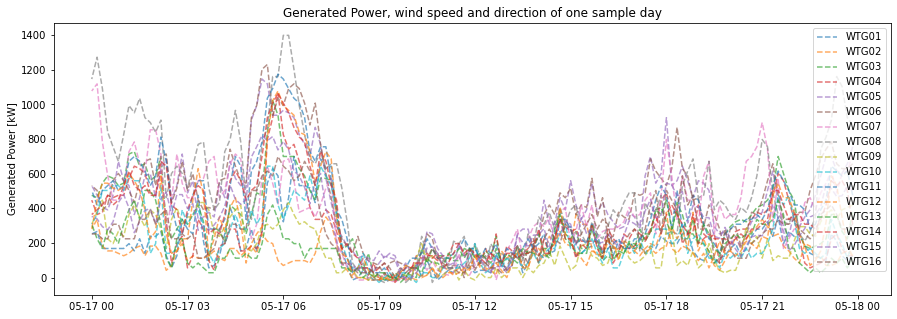

In [275]:
fig,ax = plt.subplots(figsize = (15,5))
for wt in wt_list:
    
    df = wt_95_all[wt]
    df = df[df['Date-time'].apply(lambda x:x.year)==2020]
    df = df[df.Day_Month==day]
    if wt == 'WTG10':
        dfdir = df.copy()
    plt.plot(df['Date-time'],df.Power,'--',label = wt,alpha = 0.65)
    plt.ylabel('Generated Power [kW]')
    plt.legend()
plt.title('Generated Power, wind speed and direction of one sample day')
fig.savefig('all_power.png',dpi = 400,bbox_inches="tight")

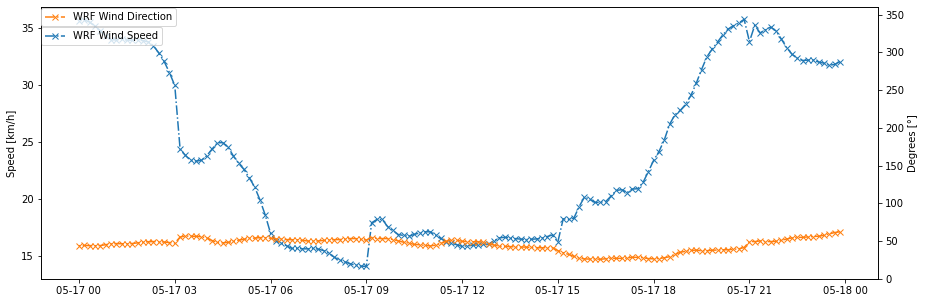

In [276]:
fig,ax = plt.subplots(figsize = (15,5))
ax2 = ax.twinx()
ax.plot(dfdir['Date-time'],dfdir.Ws*3.6,'x-.',label = 'WRF Wind Speed')
ax2.plot(dfdir['Date-time'],dfdir.Wdir,'C1x-.',label = 'WRF Wind Direction')
ax2.set_ylim([0,360])
ax2.set_ylabel('Degrees [°]')
ax.set_ylabel('Speed [km/h]')
ax.legend(loc = (0.00,0.86))
ax2.legend(loc = (0.00,0.93))
fig.savefig('ws_wdir.png',dpi = 400,bbox_inches="tight")

In [18]:
%config Completer.use_jedi = False

### The outlier problem in  wind speed-power curves
many power values at 0 or extremly low even at high wind speeds

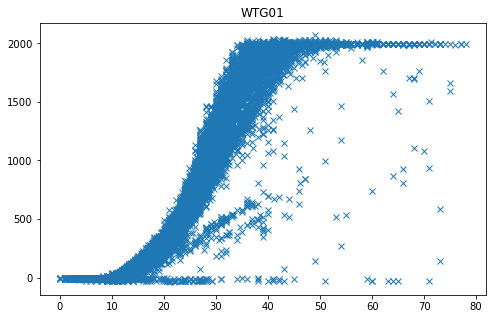

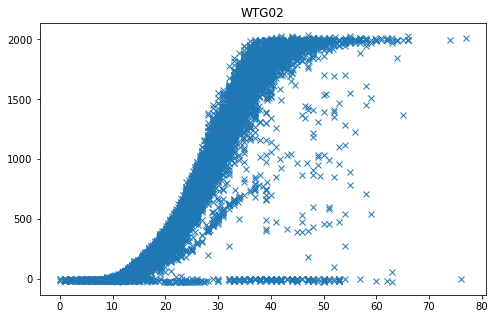

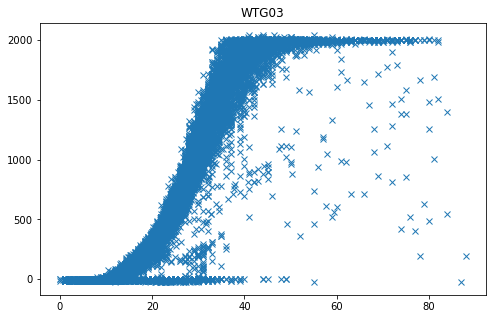

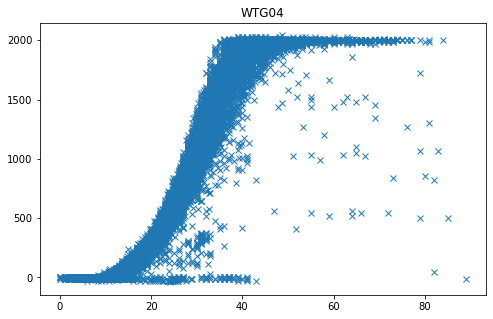

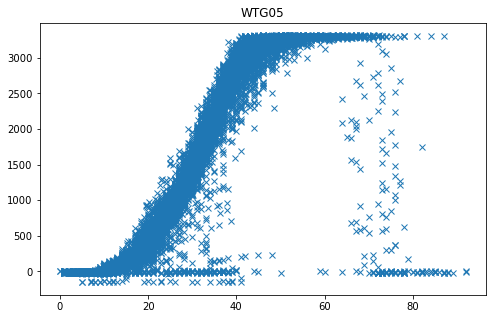

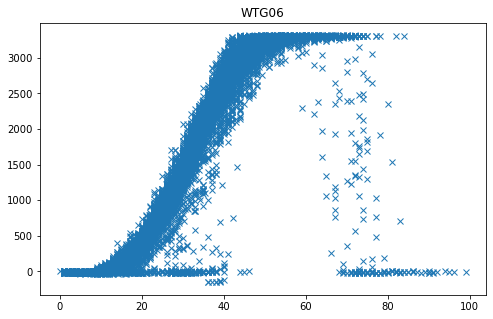

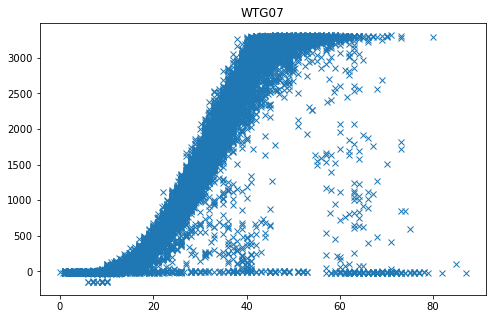

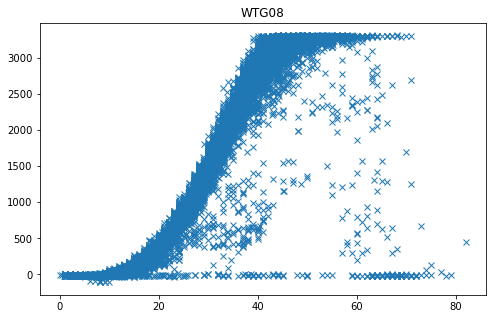

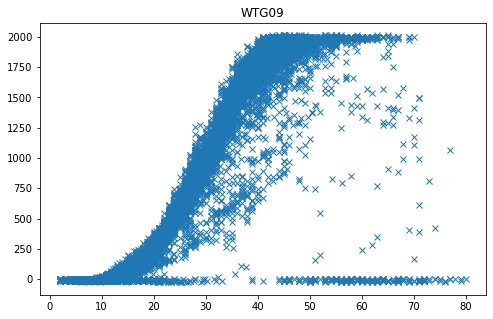

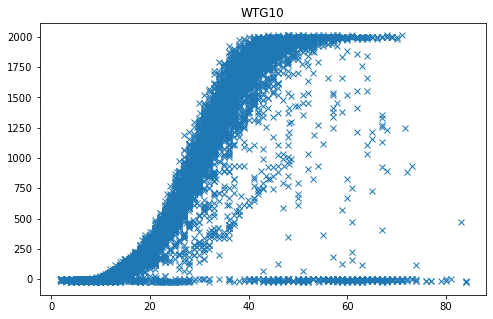

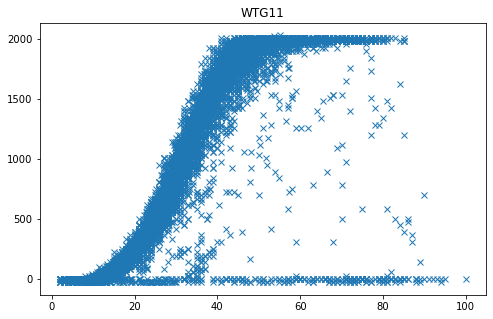

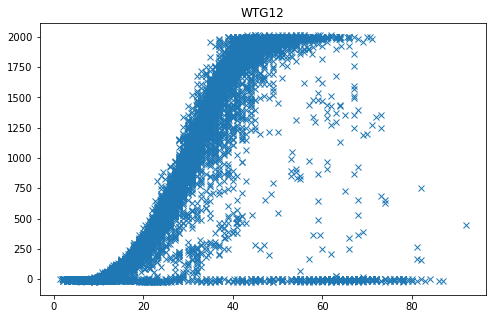

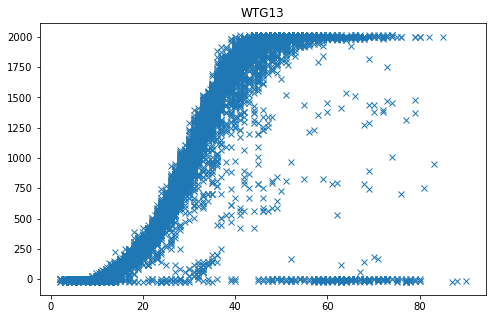

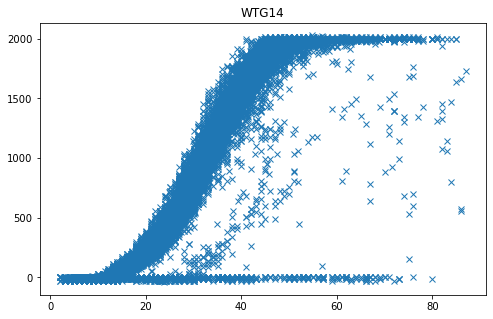

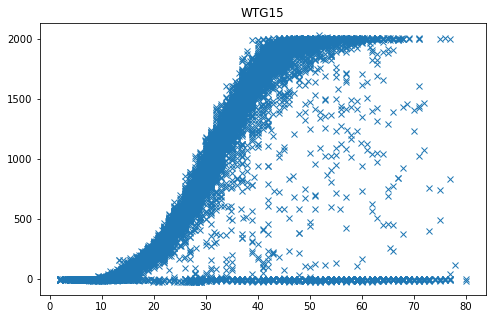

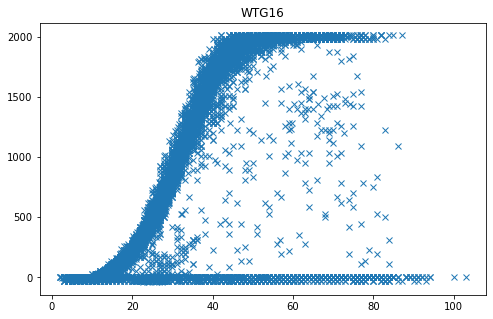

In [18]:
for wt in wt_list:
    fig,ax = plt.subplots(figsize=(8,5))
    plt.plot(wt_95_all[wt].Wind_Speed.values,wt_95_all[wt].Power.values,'x')
    plt.title(wt)
    plt.show()

### lets fit a curve to eliminate erroneous values

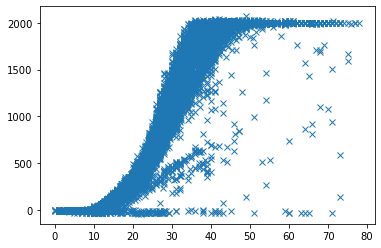

In [19]:
df_aux = wt_95_all['WTG01'].copy()
plt.plot(df_aux.Wind_Speed.values,df_aux.Power.values,'x')

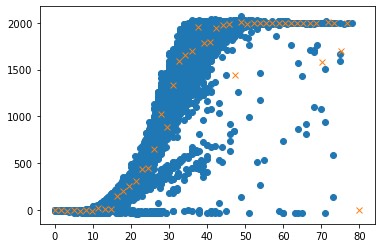

In [20]:
# Interpolation, works but not great. 
df_aux = df_aux.sort_values(by='Wind_Speed')
p_interp = np.interp(np.linspace(0,80),df_aux['Wind_Speed'].values,df_aux['Power'].values)
plt.plot(np.linspace(0,80),p_interp,'xC1')
plt.scatter(df_aux['Wind_Speed'].values,df_aux['Power'].values)

In [21]:
from operational_analysis.toolkits.power_curve.functions import logistic_5_parametric,gam,IEC

In [22]:
df_aux = df_aux.dropna()

In [23]:
lpc = logistic_5_parametric(df_aux['Wind_Speed'],df_aux['Power'])
gpc = gam(df_aux['Wind_Speed'],df_aux['Power'],n_splines=15)
iec = IEC(df_aux['Wind_Speed'],df_aux['Power'],windspeed_end=90.0)

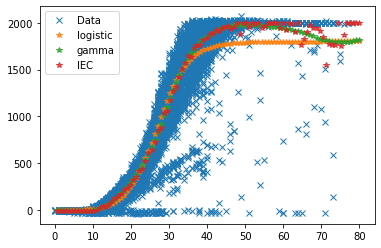

In [24]:
ws_xx = np.linspace(0.5,80,num = 100)

plt.plot(df_aux['Wind_Speed'].values,df_aux['Power'].values,'x',label = 'Data')
plt.plot(ws_xx,lpc(ws_xx),'*',alpha = 0.8,label = 'logistic')
plt.plot(ws_xx,gpc(ws_xx),'*',alpha = 0.8,label = 'gamma')
plt.plot(ws_xx,iec(ws_xx),'*',alpha = 0.8,label = 'IEC')
plt.legend()
plt.show()

In [25]:
## now lets stablish an outlier detection method
def wind_outlier(f,ws,power,w_start = 0.01, w_end = 80, p_start = 0, p_end = 2000,num = 50, alpha = 0.15):
    """
    return 0 if outlier
           1 if not 
    """
    
    ws_xx = np.linspace(w_start,w_end,num)
    p_yy = f(ws_xx)/p_end
    ws_xx = ws_xx/w_end
    outlier = []
    for a,b in zip(ws,power):
        min_dist = np.inf
        for i,j in zip(ws_xx,p_yy):
            tmp = np.sqrt((i-a/w_end)**2 + (j-b/p_end)**2)
            if min_dist > tmp:
                min_dist = tmp
        if min_dist < alpha:
            outlier.append(1)
        else:
            outlier.append(0)
    return outlier

In [26]:
outliers = wind_outlier(lpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,alpha = 0.2)

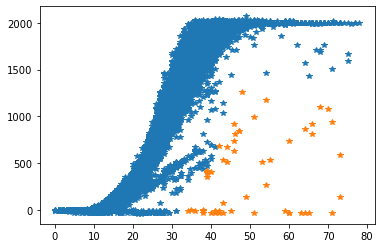

In [27]:
plt.plot(df_aux[np.array(outliers,dtype=bool)].Wind_Speed.values,df_aux[np.array(outliers,dtype=bool)].Power.values,'*')
plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

### Outlier detection looks good now
we can apply it to the entire dataset, we use a two stage outlier detection

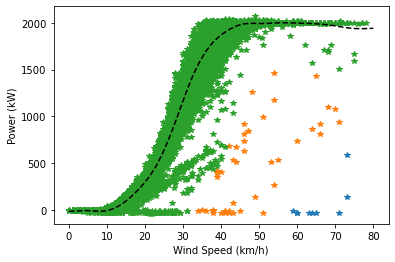

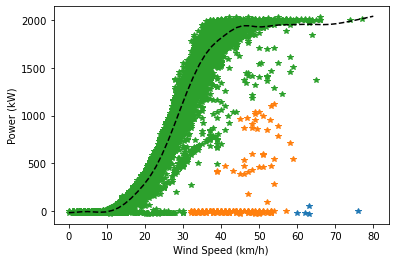

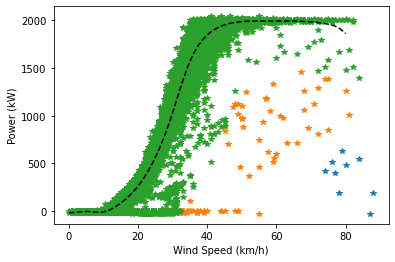

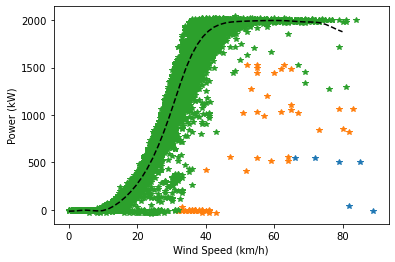

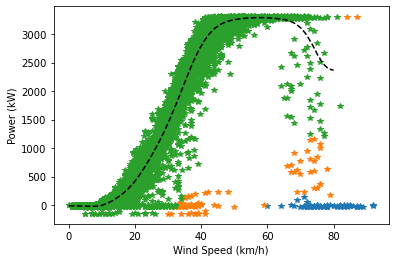

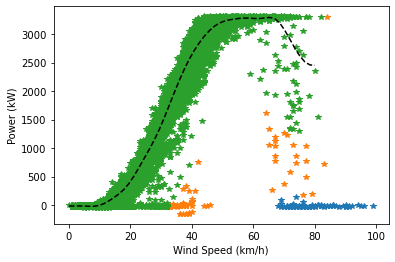

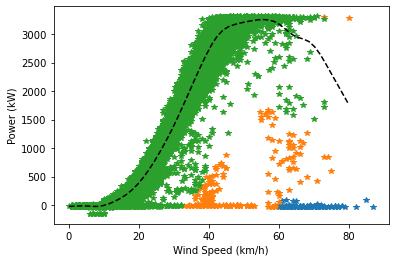

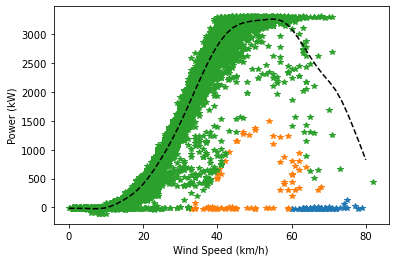

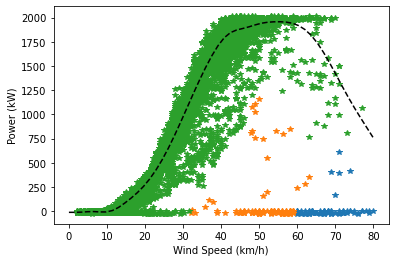

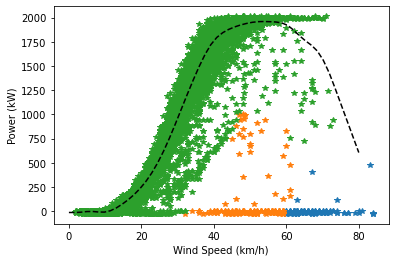

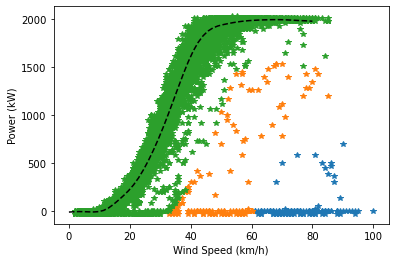

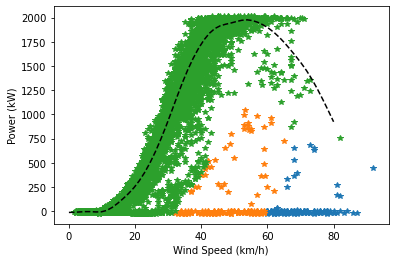

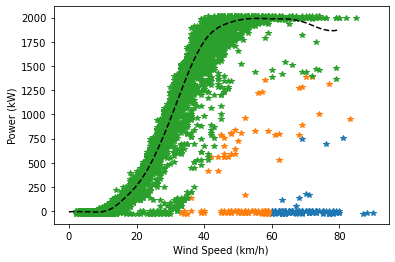

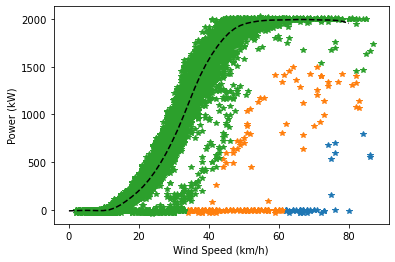

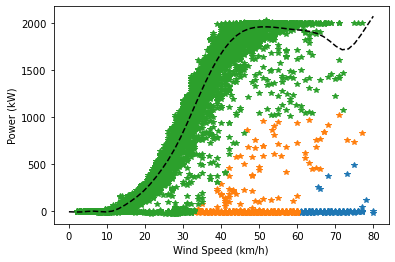

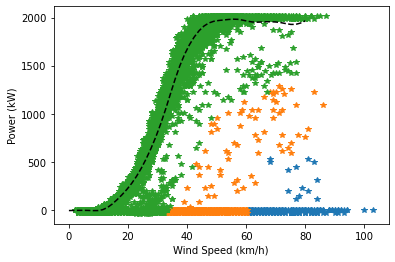

In [29]:
wt_95_all_filtered,wt_150_all_filtered = {},{}
for wt in wt_list:
    
    fig,ax = plt.subplots(figsize=(6,4))
    df_aux = wt_95_all[wt].dropna()
    df_aux2 = wt_150_all[wt].dropna()

    gpc = logistic_5_parametric(df_aux['Wind_Speed'],df_aux['Power'])
    outliers = wind_outlier(gpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,
                            p_end = nominal_power[wt],alpha = 0.5)

    plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,
             df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

    df_aux = df_aux[np.array(outliers,dtype=bool)]
    df_aux2 = df_aux2[np.array(outliers,dtype=bool)]
    
    gpc = gam(df_aux['Wind_Speed'],df_aux['Power'])
    outliers = wind_outlier(gpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,
                            p_end = nominal_power[wt],alpha = 0.2)

    plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,
             df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

    df_aux = df_aux[np.array(outliers,dtype=bool)]
    df_aux2 = df_aux2[np.array(outliers,dtype=bool)]    
    
    plt.xlabel('Wind Speed (km/h)')
    plt.ylabel('Power (kW)')
    
    plt.plot(df_aux.Wind_Speed.values,df_aux.Power.values,'*')
    
    gpc = gam(df_aux['Wind_Speed'],df_aux['Power'])
    
    plt.plot(np.linspace(0,80),gpc(np.linspace(0,80)),'k--',)
    
    wt_95_all_filtered[wt] = df_aux
    wt_150_all_filtered[wt] = df_aux2
    plt.show()
    
    if wt == 'WTG10':
        fig.savefig('outlier_wspc.pdf',bbox_inches='tight')

In [30]:
for wt in wt_list: # again remove incomplete days due to outlier deletion
    tmp = Counter(wt_95_all_filtered[wt].Day_Month)
    ic_day = [i for i,j in zip(tmp.keys(),tmp.values()) if j < 50]
    wt_95_all_filtered[wt] = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x : x not in ic_day)]
    wt_150_all_filtered[wt] = wt_150_all_filtered[wt][wt_150_all_filtered[wt].Day_Month.apply(lambda x : x not in ic_day)]
    print(len(ic_day))

0
0
0
0
0
0
0
1
0
2
1
1
1
0
2
8


### Now that the data is in order, we can fit the forecast model
First we extract a validation set from the data, four entire days per month selected randomly. the remaning data will be split into training and testing set by the NN, we dont have to do that manually.

In [31]:
month_days_dict = {}
month_days_test = []
for m in range(1,13):
    month_days_dict[m] = []
    for s in wt_95_all_filtered['WTG01'].Day_Month.unique():
        if int(s.split('_')[1]) == m:
            month_days_dict[m].append(s.split('_')[0])
    for i in random.sample(range(0, len(month_days_dict[m])), 4):
        month_days_test.append(str(m)+'_'+str(month_days_dict[m][i]))

In [32]:
#save the desired run so that we can reproduce the results
month_days_test =['1_5','1_9','1_10','1_19','2_5','2_3','2_18','2_4','3_26','3_18','3_21','3_13','4_23','4_7',
 '4_21','4_4','5_14','5_20','5_24','5_17','6_21','6_2','6_16','6_18','7_26','7_16','7_21','7_19','8_24','8_6',
 '8_4','8_5','9_10','9_7','9_20','9_13','10_24','10_5','10_4','10_13','11_28','11_25','11_7','11_10','12_3',
 '12_16','12_21','12_1']

In [33]:
#split the data
wt_95_retrain, wt_95_test,wt_150_retrain, wt_150_test = {},{},{},{}
for wt in wt_list:
    wt_95_retrain[wt]  = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x not in month_days_test)]
    wt_95_test[wt]     = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x in month_days_test)]
    wt_150_retrain[wt] = wt_150_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x not in month_days_test)]
    wt_150_test[wt]    = wt_150_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x in month_days_test)]

#### Now we can train the NN with the desired parameters

In [34]:
wnn_dict = {}
all_stats = {}
for wt in wt_list:
    print('----------------------')
    print('------  '+wt+'  ------')
    print('----------------------')
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Power',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=12,
                                time_jump=1,
                                q_weight=1.55,
                                quantile=0.55,
                                include_tanh = True,
                                patience = 2,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 1)  # Create and fit the model  you can set verbose to 1 to see the training evolution
    wnn.predict_and_getmetrics_test()
    print(wnn.stats)
    all_stats[wt] = wnn.stats
    wnn_dict[wt] = wnn

----------------------
------  WTG01  ------
----------------------
Epoch 1/45
799/799 [==============================] - 2s 2ms/step - loss: 0.4000 - val_loss: 0.3186
Epoch 2/45
799/799 [==============================] - 1s 1ms/step - loss: 0.3468 - val_loss: 0.3030
Epoch 3/45
799/799 [==============================] - 1s 1ms/step - loss: 0.3105 - val_loss: 0.2938
Epoch 4/45
799/799 [==============================] - 1s 1ms/step - loss: 0.3076 - val_loss: 0.2915
Epoch 5/45
799/799 [==============================] - 1s 1ms/step - loss: 0.2978 - val_loss: 0.2931
Epoch 6/45
799/799 [==============================] - 1s 2ms/step - loss: 0.2871 - val_loss: 0.2689
Epoch 7/45
799/799 [==============================] - 1s 2ms/step - loss: 0.2769 - val_loss: 0.2748
Epoch 8/45
799/799 [==============================] - 1s 2ms/step - loss: 0.2716 - val_loss: 0.2605
Epoch 9/45
799/799 [==============================] - 1s 2ms/step - loss: 0.2741 - val_loss: 0.2573
Epoch 10/45
799/799 [===========

In [35]:
## Save the trained models
#with open('wnn_dict_final.pickle', 'wb') as handle:
#    pickle.dump(wnn_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### use the NN trained above to predict the validation set

------  WTG01  ------
MAE = 11.5
RMSE = 16.1
MedAE = 7.78
ME = 86.69


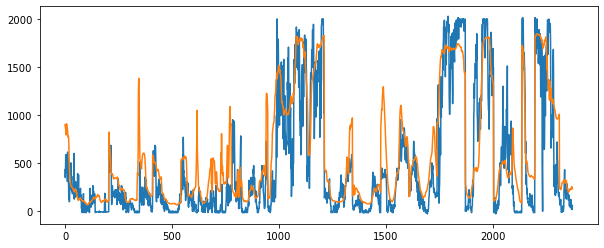

------  WTG02  ------
MAE = 9.74
RMSE = 14.46
MedAE = 5.69
ME = 68.11


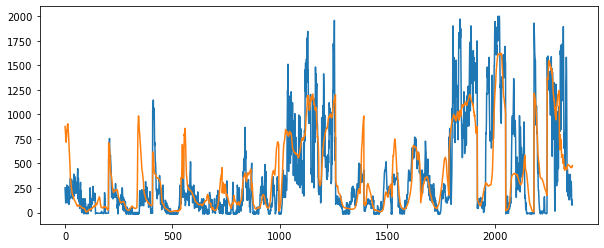

------  WTG03  ------
MAE = 11.64
RMSE = 18.31
MedAE = 5.98
ME = 91.77


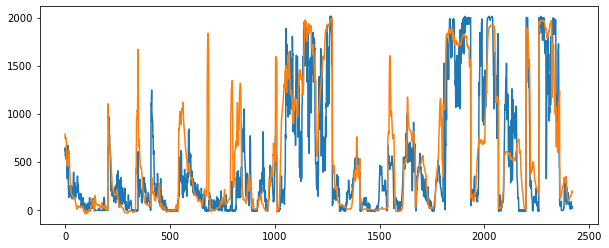

------  WTG04  ------
MAE = 12.14
RMSE = 17.96
MedAE = 7.5
ME = 85.33


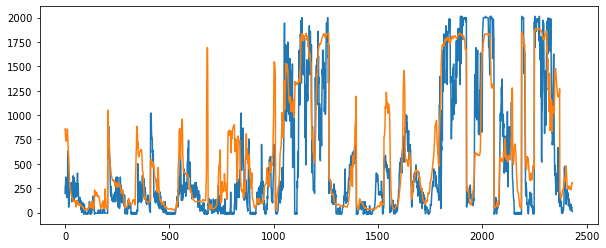

------  WTG05  ------
MAE = 12.96
RMSE = 18.37
MedAE = 7.9
ME = 84.02


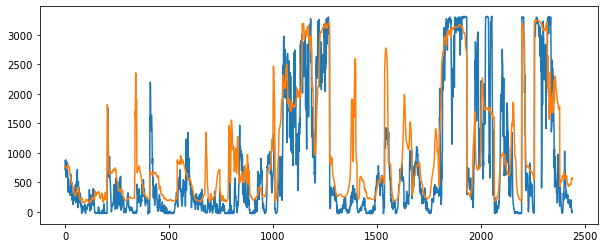

------  WTG06  ------
MAE = 10.86
RMSE = 16.33
MedAE = 6.31
ME = 69.65


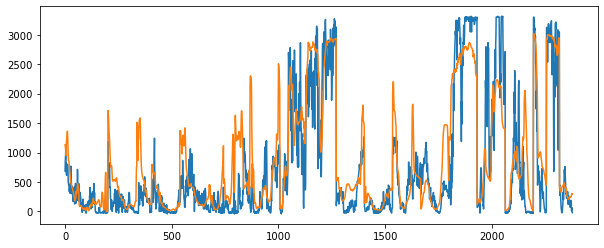

------  WTG07  ------
MAE = 11.89
RMSE = 17.78
MedAE = 6.66
ME = 76.08


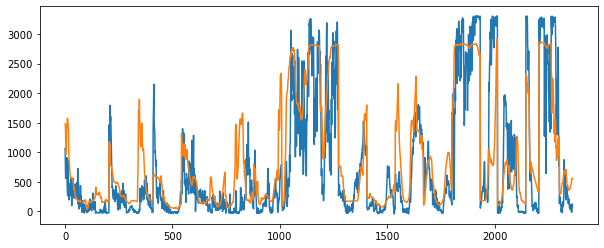

------  WTG08  ------
MAE = 11.16
RMSE = 16.16
MedAE = 7.22
ME = 82.16


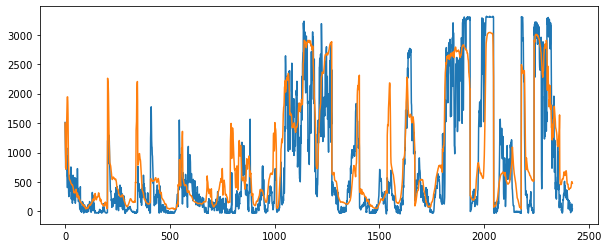

------  WTG09  ------
MAE = 10.45
RMSE = 16.58
MedAE = 5.95
ME = 88.66


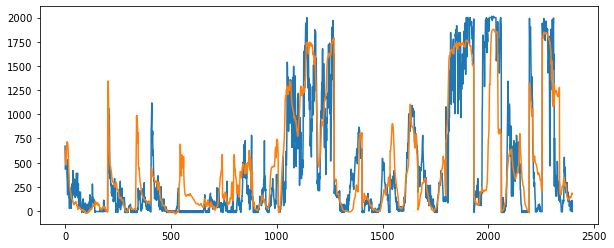

------  WTG10  ------
MAE = 12.54
RMSE = 17.14
MedAE = 8.47
ME = 81.46


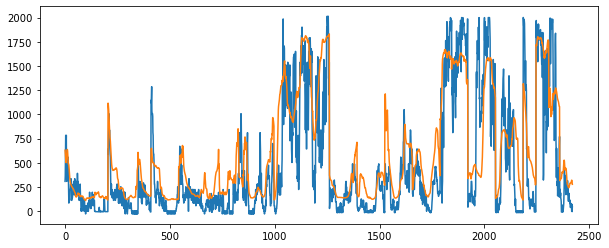

------  WTG11  ------
MAE = 11.36
RMSE = 16.69
MedAE = 6.91
ME = 74.51


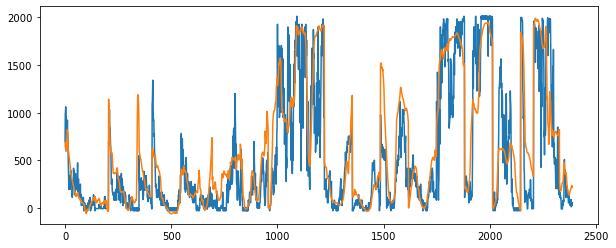

------  WTG12  ------
MAE = 11.1
RMSE = 15.9
MedAE = 7.58
ME = 83.54


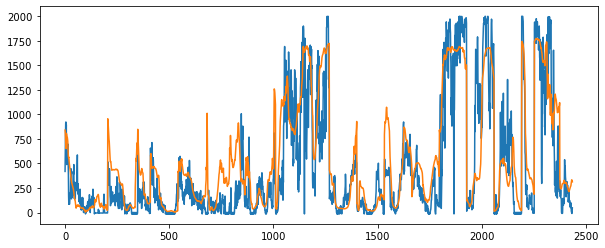

------  WTG13  ------
MAE = 12.36
RMSE = 19.16
MedAE = 6.97
ME = 85.72


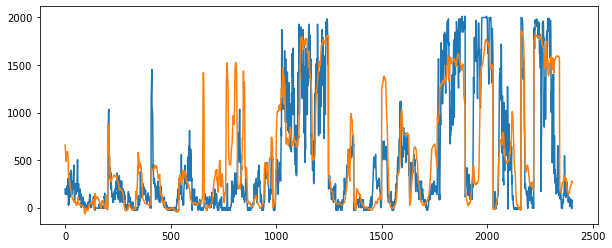

------  WTG14  ------
MAE = 14.03
RMSE = 21.02
MedAE = 8.04
ME = 91.94


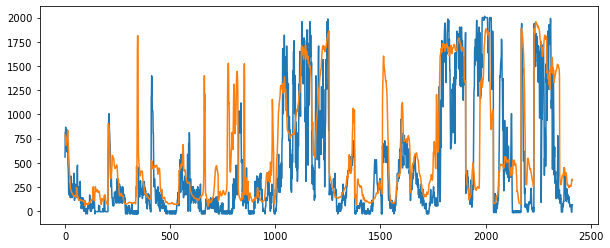

------  WTG15  ------
MAE = 12.4
RMSE = 18.37
MedAE = 7.38
ME = 85.86


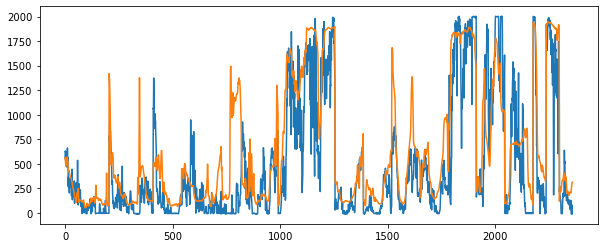

------  WTG16  ------
MAE = 12.41
RMSE = 19.02
MedAE = 7.69
ME = 84.65


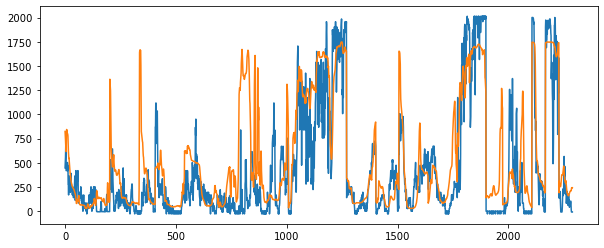

In [36]:
val_stats={}
for wt in wt_list:
    print('------  '+wt+'  ------')
    dfout = wnn_dict[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout)
    val_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        val_stats[wt].append(100*stats[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(val_stats[wt][-1],2)))
        
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Power.values)
    plt.plot(dfout.Predicted_Power.values)
    plt.show()

In [37]:
wnn_dict['WTG01'].model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104)               10920     
_________________________________________________________________
dense_1 (Dense)              (None, 69)                7245      
_________________________________________________________________
dense_2 (Dense)              (None, 69)                4830      
_________________________________________________________________
dropout (Dropout)            (None, 69)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 52)                3640      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 52)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 52)                2

------  WTG01  ------
MAE = 11.5
RMSE = 16.1
MedAE = 7.78
ME = 86.69


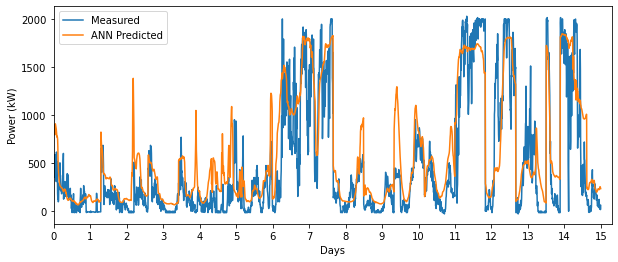

------  WTG02  ------
MAE = 9.74
RMSE = 14.46
MedAE = 5.69
ME = 68.11


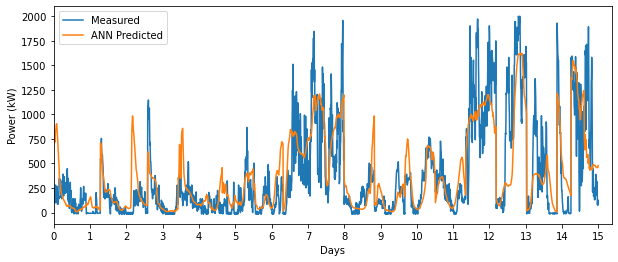

------  WTG03  ------
MAE = 11.64
RMSE = 18.31
MedAE = 5.98
ME = 91.77


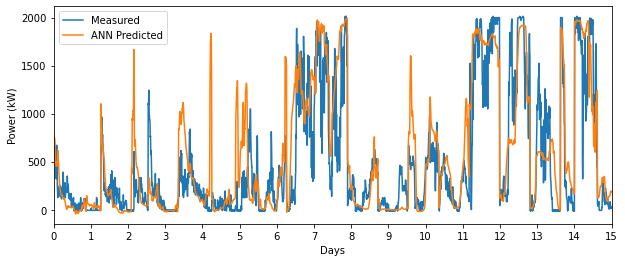

------  WTG04  ------
MAE = 12.14
RMSE = 17.96
MedAE = 7.5
ME = 85.33


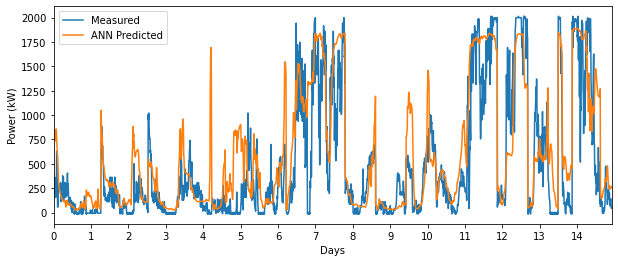

------  WTG05  ------
MAE = 12.96
RMSE = 18.37
MedAE = 7.9
ME = 84.02


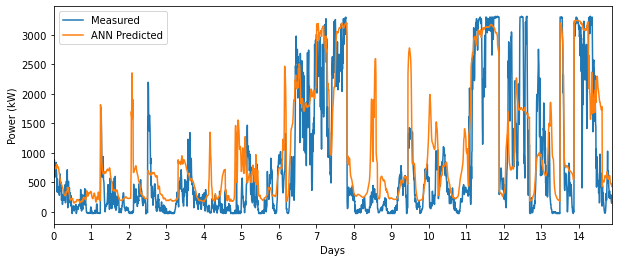

------  WTG06  ------
MAE = 10.86
RMSE = 16.33
MedAE = 6.31
ME = 69.65


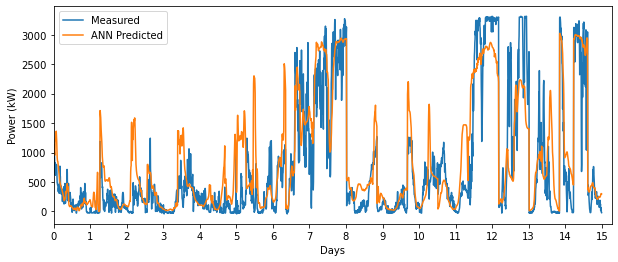

------  WTG07  ------
MAE = 11.89
RMSE = 17.78
MedAE = 6.66
ME = 76.08


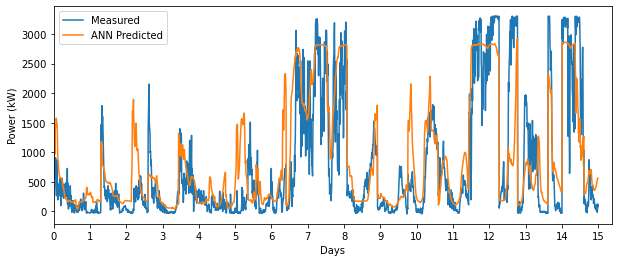

------  WTG08  ------
MAE = 11.16
RMSE = 16.16
MedAE = 7.22
ME = 82.16


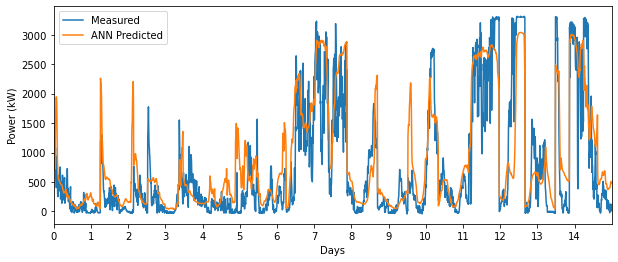

------  WTG09  ------
MAE = 10.45
RMSE = 16.58
MedAE = 5.95
ME = 88.66


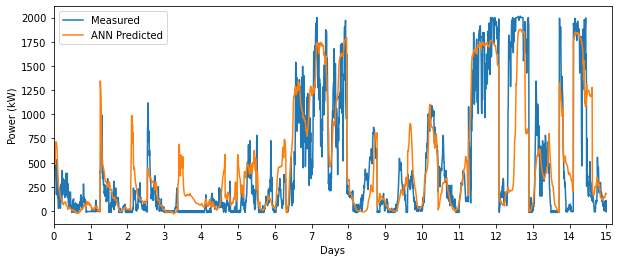

------  WTG10  ------
MAE = 12.54
RMSE = 17.14
MedAE = 8.47
ME = 81.46


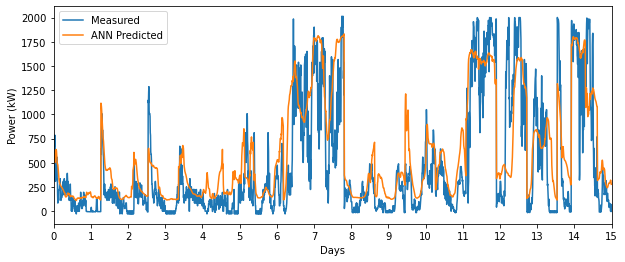

------  WTG11  ------
MAE = 11.36
RMSE = 16.69
MedAE = 6.91
ME = 74.51


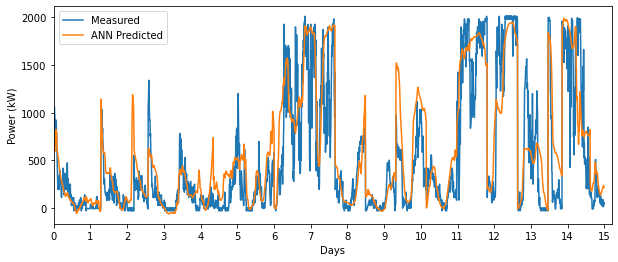

------  WTG12  ------
MAE = 11.1
RMSE = 15.9
MedAE = 7.58
ME = 83.54


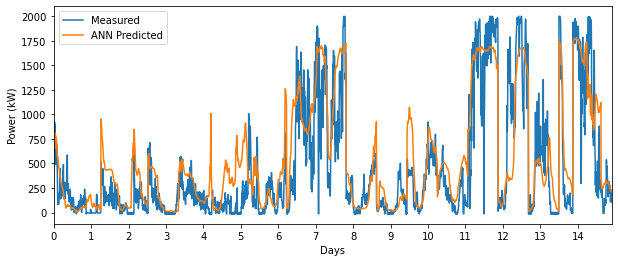

------  WTG13  ------
MAE = 12.36
RMSE = 19.16
MedAE = 6.97
ME = 85.72


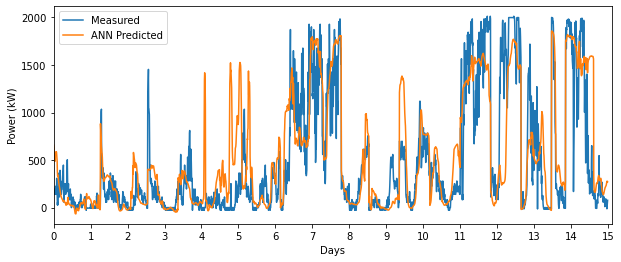

------  WTG14  ------
MAE = 14.03
RMSE = 21.02
MedAE = 8.04
ME = 91.94


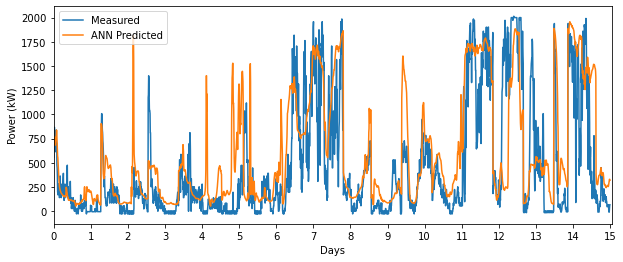

------  WTG15  ------
MAE = 12.4
RMSE = 18.37
MedAE = 7.38
ME = 85.86


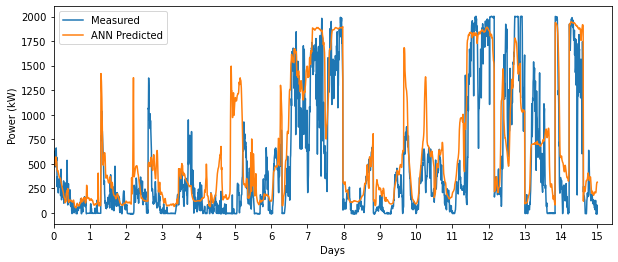

------  WTG16  ------
MAE = 12.41
RMSE = 19.02
MedAE = 7.69
ME = 84.65


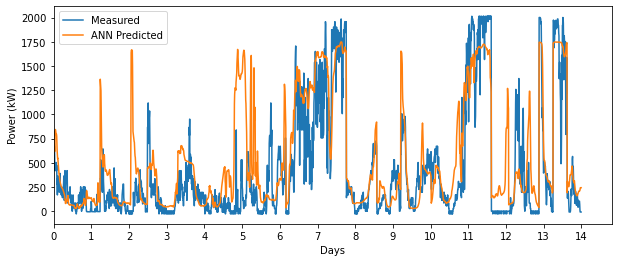

In [153]:
df_all_wt = pd.DataFrame()
val_stats={}
for tn,wt in enumerate(wt_list):
    print('------  '+wt+'  ------')
    dfout = wnn_dict[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout)
    val_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        val_stats[wt].append(100*stats[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(val_stats[wt][-1],2)))
        
    dftmp = dfout[['Power','Predicted_Power']].copy()
    dftmp['Nominal_Power'] = nominal_power[wt]
    dftmp['T_Number'] = tn
    df_all_wt = pd.concat([df_all_wt,dftmp])
    
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Power.values,label = 'Measured')
    plt.plot(dfout.Predicted_Power.values,label = 'ANN Predicted')
    
    xaux = np.arange(0,np.floor(len(dfout.Predicted_Power.values)/(24*6)))
    ax.set_xticks(np.linspace(0,len(dfout.Predicted_Power.values),len(xaux)))
    ax.set_xticklabels([int(i) for i in xaux])
    
    plt.xlabel('Days')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.xlim([0, 2420.8])
    plt.show()
    #if wt == 'WTG10':
        #use_df = dfout.copy()
        #fig.savefig('forecast_timeplot.pdf',bbox_inches='tight')
    
   

In [154]:
df_all_wt.head()

Power  Predicted_Power  Nominal_Power  T_Number
1314  433.0       901.942567           2000         0
1315  350.0       875.675250           2000         0
1316  405.0       870.512579           2000         0
1317  587.0       846.914476           2000         0
1318  503.0       798.088796           2000         0

In [67]:
dfout['dmh'] = dfout['Date-time'].dt.strftime('%m%d%H')

In [40]:
df12 = dfout.groupby('dmh').mean()

In [41]:
stats_h = get_stats(dfout.groupby('dmh').mean())

In [42]:
tmp = []
for i in list(stats_h.keys())[1:]:
        tmp.append(100*stats_h[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(tmp[-1],2)))

MAE = 11.3
RMSE = 17.23
MedAE = 6.53
ME = 90.42


#### Normalize prediction statistics by the nominal power of the wind turbines

In [43]:
for wt in all_stats:  # convert stats into percentge except for R2
    tmp = all_stats[wt]
    tmp[2] = np.sqrt(tmp[2])
    all_stats[wt] = [tmp[0]] + [100*i / nominal_power[wt] for i in tmp[1:]]

In [44]:
df = pd.DataFrame(all_stats)
df_val = pd.DataFrame(val_stats)

In [45]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(np.round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    return ax
        
        
def bar_metrics(x1,x2,labels,ylabel,title,width = 0.35,loc = 3,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=figsize)
    xx = np.arange(len(labels))  # the label locations
      # the width of the bars

    rects1 = ax.bar(xx - width/2, x1, width, label='Test Set')
    rects2 = ax.bar(xx + width/2, x2, width, label='Validation Set')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel,fontsize = 14)
    ax.set_title(title)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.legend(loc = loc)
    ax = autolabel(ax,rects1)
    ax = autolabel(ax,rects2)
    plt.show()
    return fig, ax

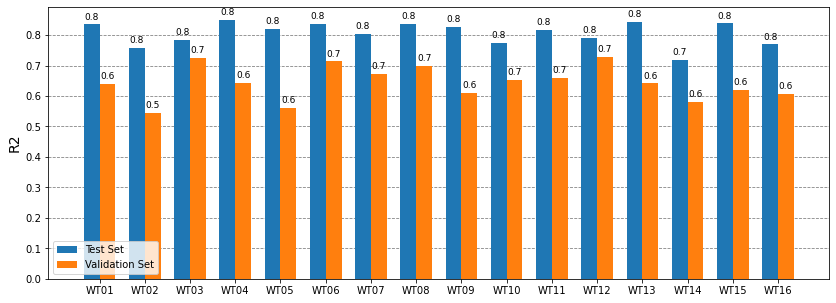

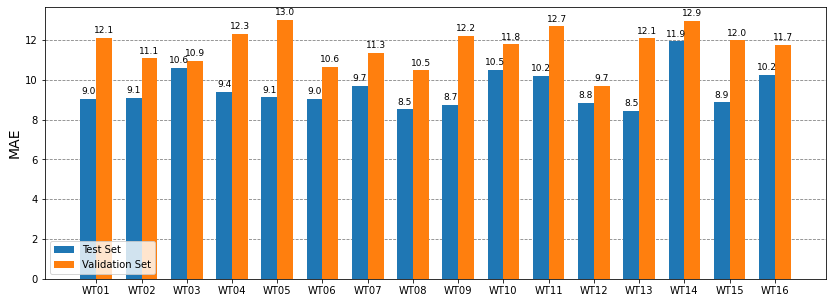

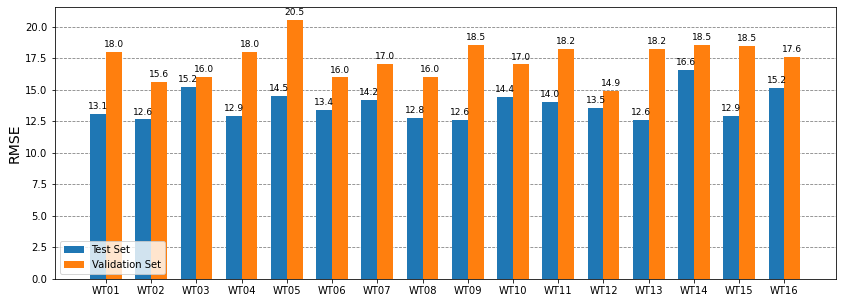

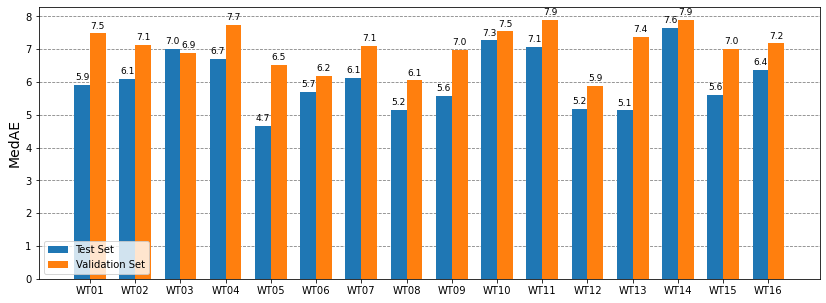

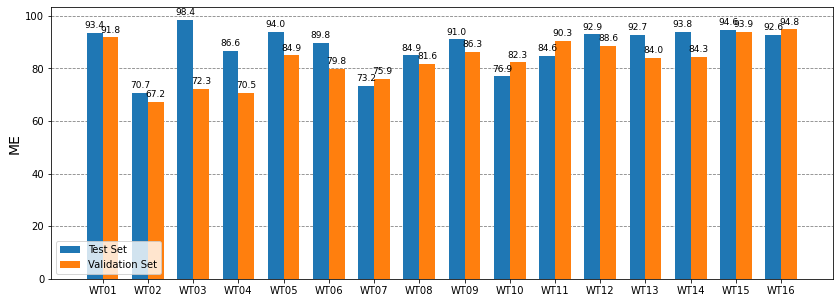

In [46]:
labels = [''.join(i.split('G')) for i in df.columns]
for i,s in enumerate(['R2', 'MAE', 'RMSE', 'MedAE', 'ME']):
    fig, ax = bar_metrics(df.iloc[i],df_val.iloc[i],labels,s,'',figsize=(14,5))
    #fig.savefig('bar_'+s+'.pdf')

#### We need to compare the performance of the direct power prediction from the ANN with a baseline model, we chose to directly predict power from the WRF wind speed, usgin a wind speed-power curve fitted with a gamma curve as baseline

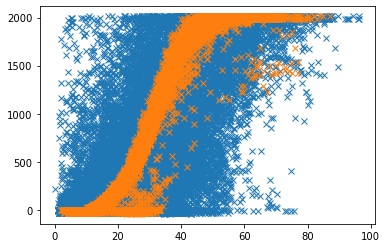

In [47]:
plt.plot(wt_95_retrain[wt]['Ws'].values*3.6,wt_95_retrain[wt]['Power'].values,'x')
plt.plot(wt_95_retrain[wt]['Wind_Speed'].values,wt_95_retrain[wt]['Power'].values,'x')

In [155]:
df_base_all = pd.DataFrame()
base1_stats={}
for tn,wt in enumerate(wt_list):
    gpc = gam(wt_95_retrain[wt]['Wind_Speed'],wt_95_retrain[wt]['Power'])
    dftmp = pd.DataFrame({'Power':wt_95_test[wt]['Power'].values,
                          'Predicted_Power':gpc(wt_95_test[wt]['Ws'].values*3.6)})
    stats = get_stats(dftmp)
    base1_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        base1_stats[wt].append(100*stats[i]/nominal_power[wt])
        
    dftmp['Nominal_Power'] = nominal_power[wt]
    dftmp['T_Number'] = tn
    df_base_all = pd.concat([df_base_all,dftmp])

In [156]:
df_base_all.head()

Power  Predicted_Power  Nominal_Power  T_Number
0  433.0      1591.760443           2000         0
1  350.0      1595.721611           2000         0
2  405.0      1621.718116           2000         0
3  587.0      1646.785929           2000         0
4  503.0      1654.415261           2000         0

In [49]:
df_base = pd.DataFrame(base1_stats)

In [50]:
def bar_metrics_3(x1,x2,x3,labels,ylabel,title,width = 0.28,loc = 3,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=figsize)
    xx = np.arange(len(labels))  # the label locations
      # the width of the bars

    rects1 = ax.bar(xx - width, x1, width, label='Test Set')
    rects2 = ax.bar(xx , x2, width, label='Validation Set')
    rects3 = ax.bar(xx + width, x3, width, label='Baseline Model')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel,fontsize = 14)
    ax.set_title(title)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.legend(loc = loc)
    ax = autolabel(ax,rects1)
    ax = autolabel(ax,rects2)
    ax = autolabel(ax,rects3)
    plt.show()
    return fig, ax

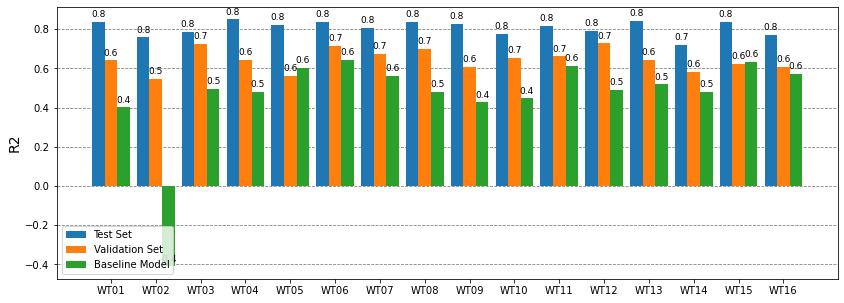

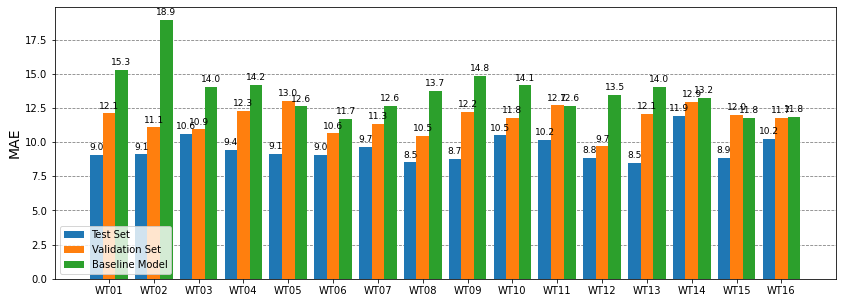

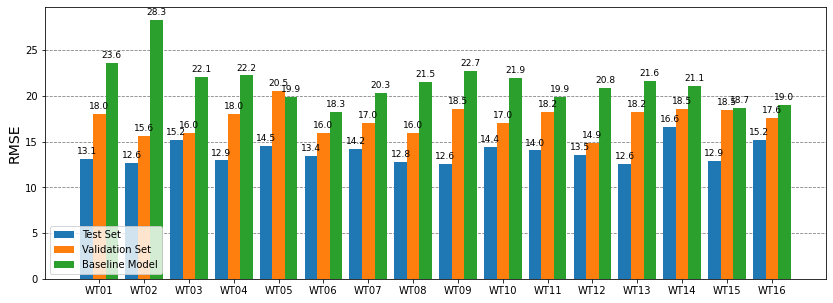

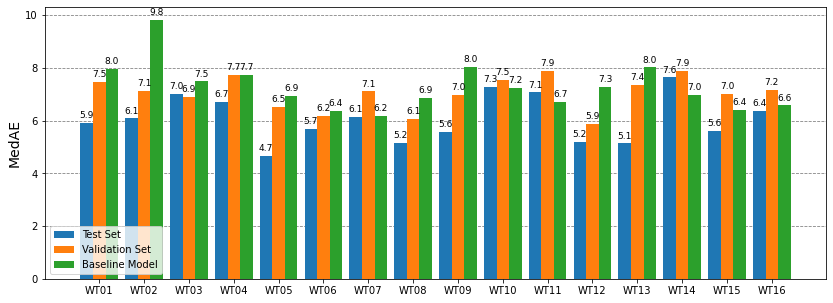

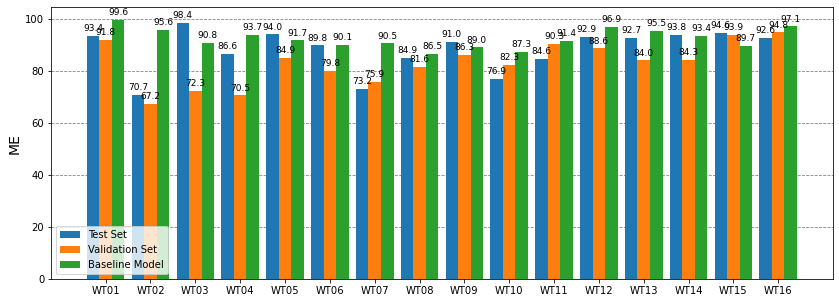

In [51]:
labels = [''.join(i.split('G')) for i in df.columns]
for i,s in enumerate(['R2', 'MAE', 'RMSE', 'MedAE', 'ME']):
    fig, ax = bar_metrics_3(df.iloc[i],df_val.iloc[i],df_base.iloc[i],labels,s,'',figsize=(14,5))
    #fig.savefig('bar_'+s+'.pdf')

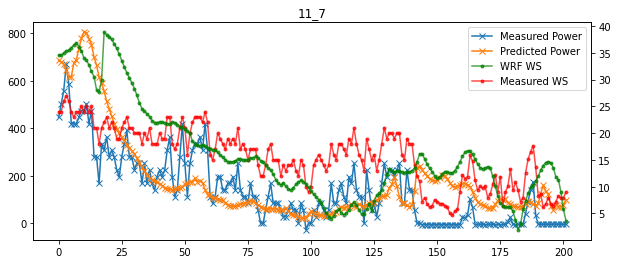

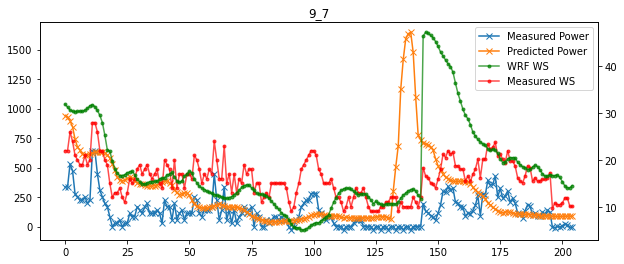

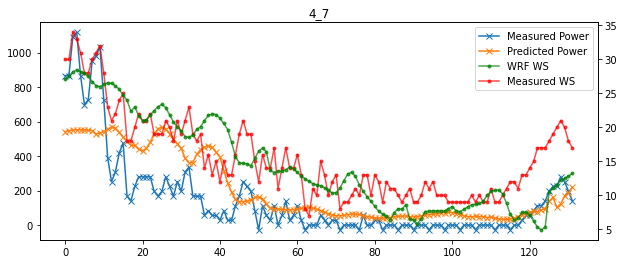

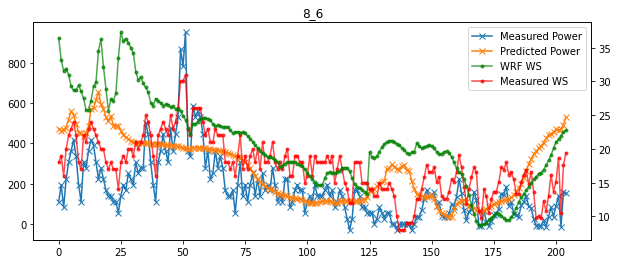

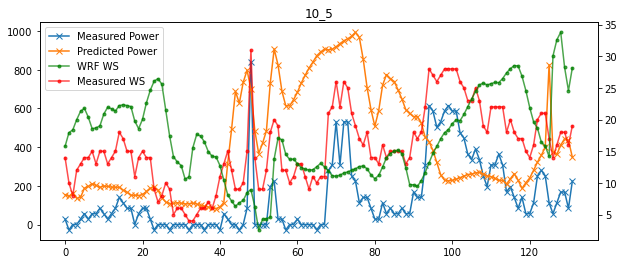

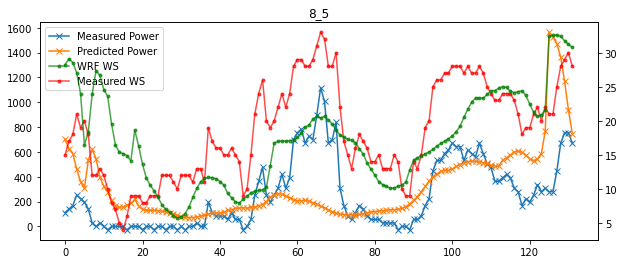

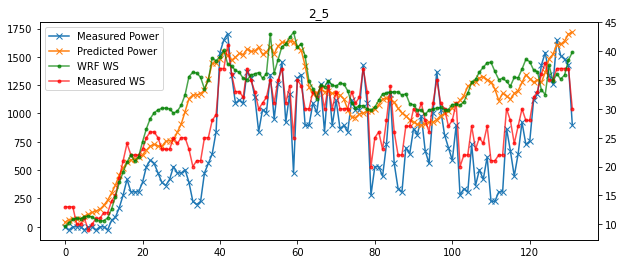

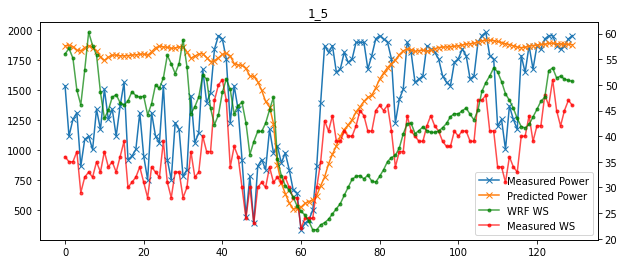

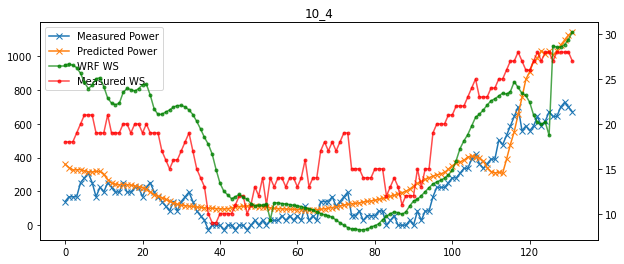

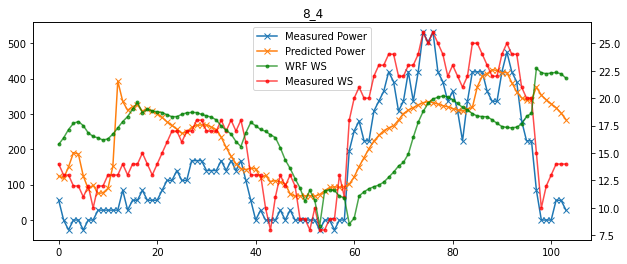

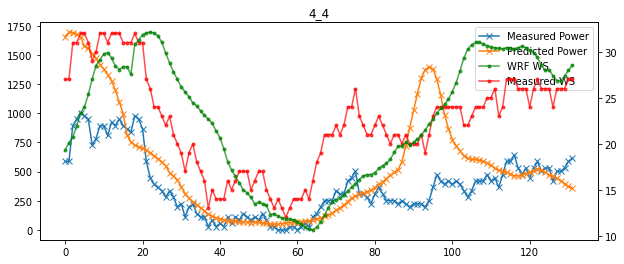

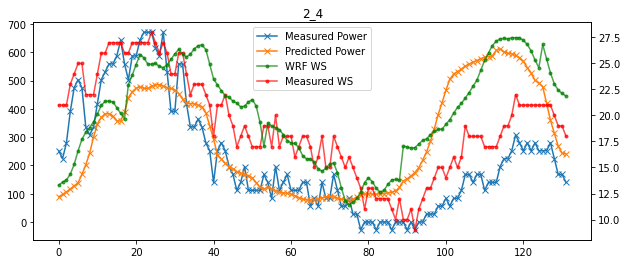

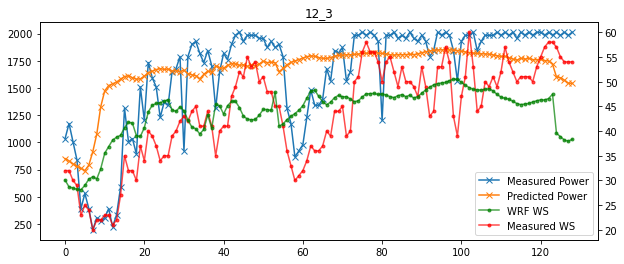

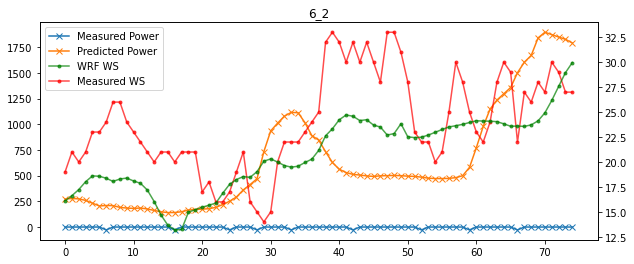

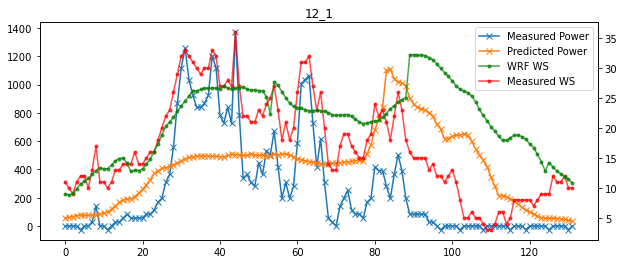

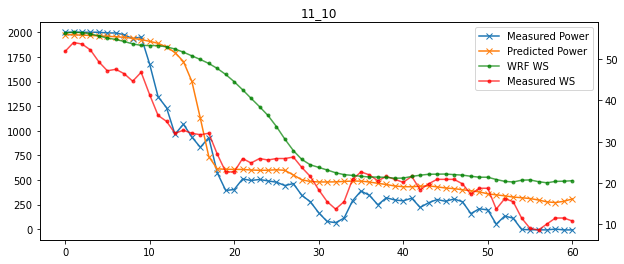

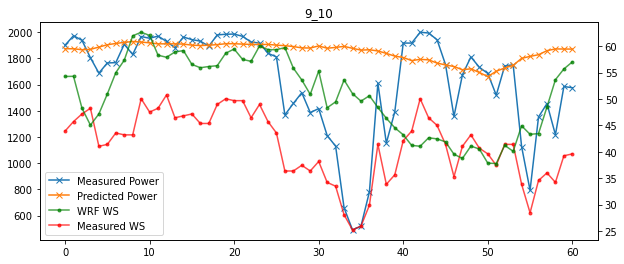

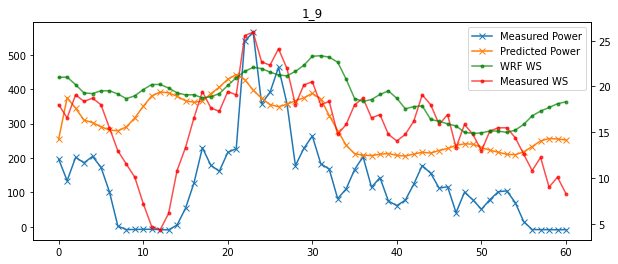

In [52]:
for dm in dfout.Day_Month.unique():
    tmp = dfout[dfout.Day_Month == dm]
    fig,ax = plt.subplots(figsize=(10,4))
    ln1 = ax.plot(tmp.Power.values,'-x',label = 'Measured Power' )
    ln2 = ax.plot(tmp.Predicted_Power.values,'-x',label = 'Predicted Power')

    ax2 = ax.twinx()
    ln4 = ax2.plot(tmp.Wind_Speed.values,'r.-',alpha = 0.7,label = 'Measured WS')
    ln3 = ax2.plot(tmp.Ws.values*3.6,'g.-',alpha = 0.7,label = 'WRF WS')
    
    
    lns = ln1+ln2+ln3+ln4
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)
    plt.title(dm)
    plt.show()

***we can also use a Neural Network to predict wind speed and then use that wind speed to predict power via a wind speed-power curve***

In [68]:
wnn_dict_ws = {}
for wt in wt_list:
    print('----------------------')
    print('------  '+wt+'  ------')
    print('----------------------')
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Wind_Speed',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=9,
                                time_jump=1,
                                q_weight=1,
                                quantile=0.6,
                                include_tanh = False,
                                patience = 2,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 1)  # Create and fit the model  you can set verbose to 1 to see the training evolution
    wnn.predict_and_getmetrics_test()
    print(wnn.stats)
    wnn_dict_ws[wt] = wnn

----------------------
------  WTG01  ------
----------------------
Epoch 1/45
821/821 [==============================] - 2s 2ms/step - loss: 0.3347 - val_loss: 0.2363
Epoch 2/45
821/821 [==============================] - 1s 1ms/step - loss: 0.2600 - val_loss: 0.2343
Epoch 3/45
821/821 [==============================] - 1s 1ms/step - loss: 0.2425 - val_loss: 0.2415
Epoch 4/45
821/821 [==============================] - 1s 1ms/step - loss: 0.2344 - val_loss: 0.2219
Epoch 5/45
821/821 [==============================] - 1s 1ms/step - loss: 0.2226 - val_loss: 0.2276
Epoch 6/45
821/821 [==============================] - 1s 2ms/step - loss: 0.2238 - val_loss: 0.2224
[0.7797154415674792, 4.033181637672343, 27.400182847437165, 3.285331342854896, 32.553880442981495]
----------------------
------  WTG02  ------
----------------------
Epoch 1/45
824/824 [==============================] - 2s 2ms/step - loss: 0.3982 - val_loss: 0.3260
Epoch 2/45
824/824 [==============================] - 1s 1ms/step

In [69]:
wnn_dict_ws['WTG01'].model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_113 (Dense)            (None, 53)                4293      
_________________________________________________________________
dense_114 (Dense)            (None, 53)                2862      
_________________________________________________________________
dropout_16 (Dropout)         (None, 53)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 40)                2160      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 28)              

In [70]:
## Save the trained models
#with open('wnn_dict_ws_final.pickle', 'wb') as handle:
#    pickle.dump(wnn_dict_ws, handle, protocol=pickle.HIGHEST_PROTOCOL)

------  WTG01  ------
MAE = 4.14
RMSE = 5.39
MedAE = 3.21
ME = 19.91


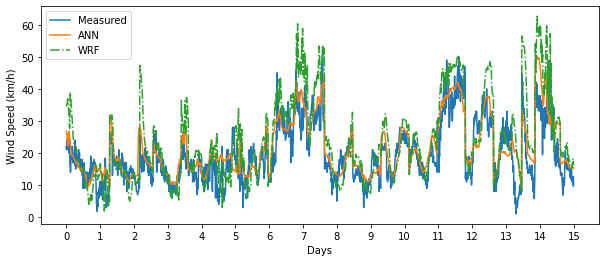

------  WTG02  ------
MAE = 3.77
RMSE = 4.83
MedAE = 3.03
ME = 18.07


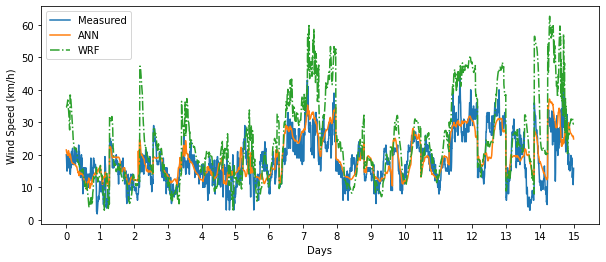

------  WTG03  ------
MAE = 4.19
RMSE = 5.44
MedAE = 3.38
ME = 24.31


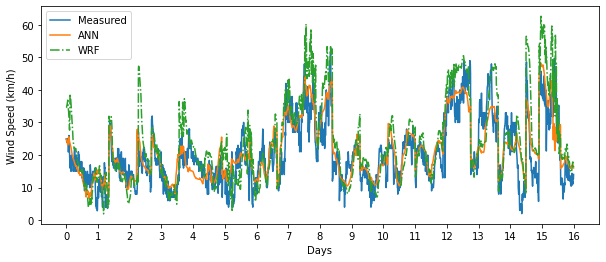

------  WTG04  ------
MAE = 4.06
RMSE = 5.26
MedAE = 3.27
ME = 23.5


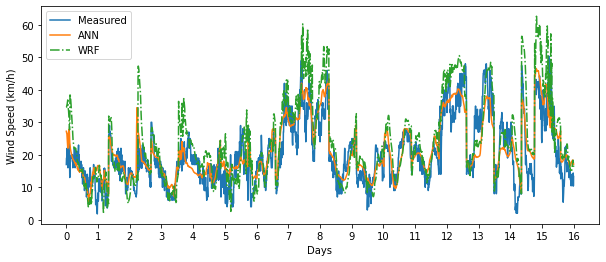

------  WTG05  ------
MAE = 5.02
RMSE = 6.61
MedAE = 3.76
ME = 24.51


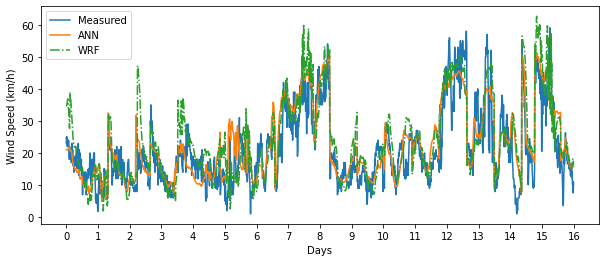

------  WTG06  ------
MAE = 5.08
RMSE = 6.78
MedAE = 3.85
ME = 31.73


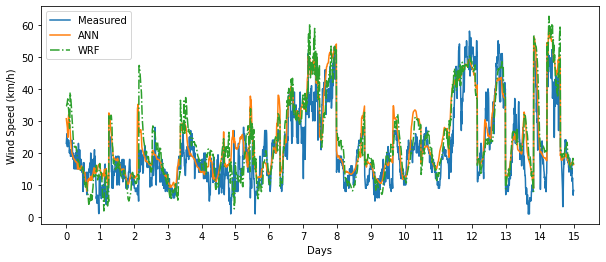

------  WTG07  ------
MAE = 4.53
RMSE = 5.94
MedAE = 3.6
ME = 23.93


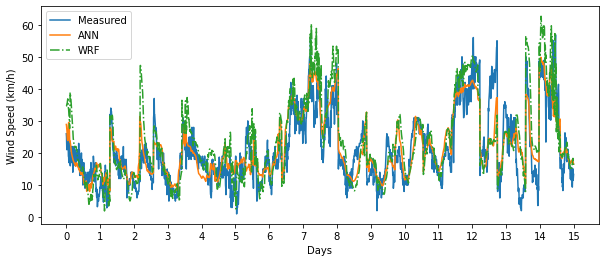

------  WTG08  ------
MAE = 4.64
RMSE = 6.15
MedAE = 3.54
ME = 25.08


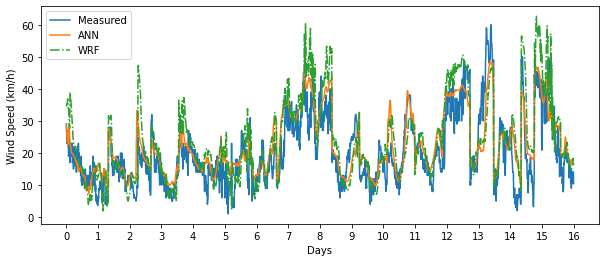

------  WTG09  ------
MAE = 4.24
RMSE = 5.63
MedAE = 3.26
ME = 22.96


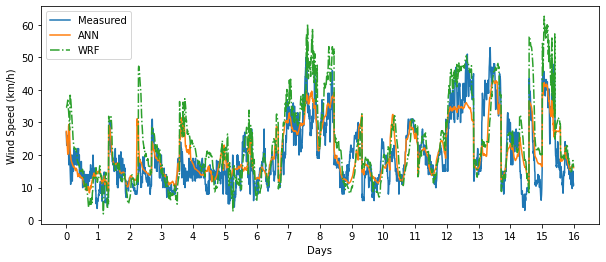

------  WTG10  ------
MAE = 4.16
RMSE = 5.43
MedAE = 3.24
ME = 22.32


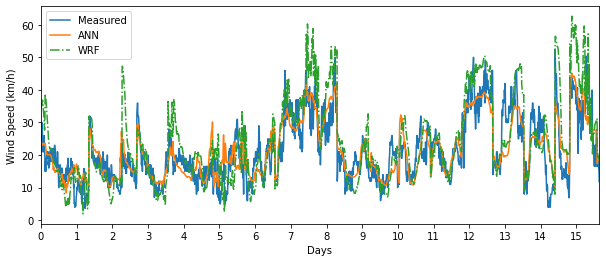

------  WTG11  ------
MAE = 5.39
RMSE = 6.89
MedAE = 4.36
ME = 31.19


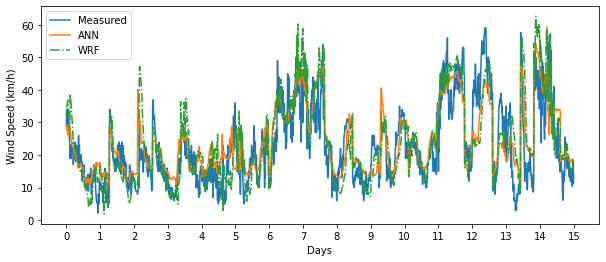

------  WTG12  ------
MAE = 4.37
RMSE = 5.75
MedAE = 3.39
ME = 27.61


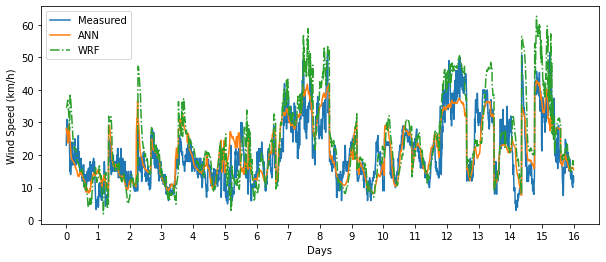

------  WTG13  ------
MAE = 4.67
RMSE = 6.2
MedAE = 3.55
ME = 25.31


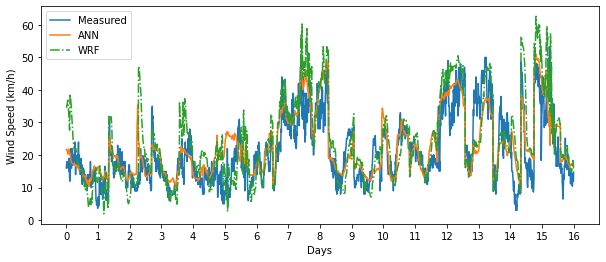

------  WTG14  ------
MAE = 5.19
RMSE = 6.8
MedAE = 4.02
ME = 26.41


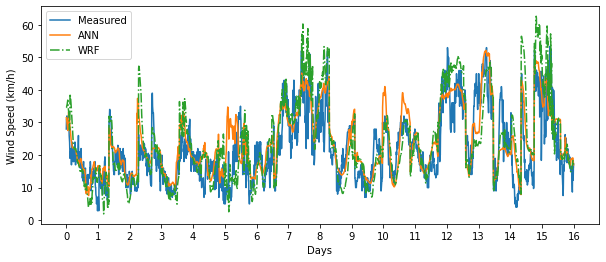

------  WTG15  ------
MAE = 4.39
RMSE = 5.81
MedAE = 3.28
ME = 22.1


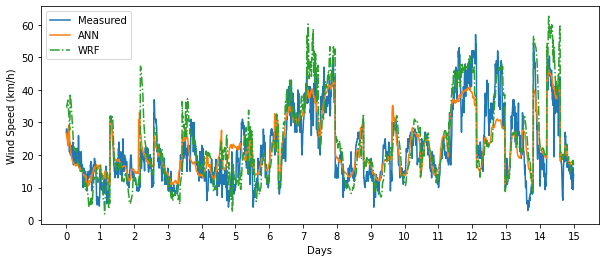

------  WTG16  ------
MAE = 4.78
RMSE = 6.44
MedAE = 3.52
ME = 30.65


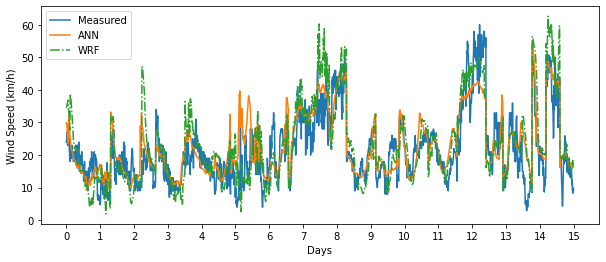

In [157]:
df_all_wt2=pd.DataFrame()
base2_stats={}
for tn,wt in enumerate(wt_list):
    print('------  '+wt+'  ------')
    dfout = wnn_dict_ws[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout,t_name='Wind_Speed')
    for i in list(stats.keys())[1:]:
        print(i +' = '+ str(np.round(stats[i],2)))
    
    
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Wind_Speed.values,label = 'Measured')
    plt.plot(dfout.Predicted_Power.values,label = 'ANN')
    plt.plot(dfout.Ws.values*3.6,'-.',label = 'WRF')
    plt.ylabel('Wind Speed (km/h)')
    plt.legend()
    
    xaux = np.arange(0,np.floor(len(dfout.Wind_Speed.values)/(24*6)))
    
    ax.set_xticks(np.linspace(0,len(dfout.Wind_Speed.values),len(xaux)))
    ax.set_xticklabels([int(i) for i in xaux])
    
    plt.xlabel('Days')
    
    if wt == 'WTG10':
            usewinddf = dfout.copy()
            plt.xlim([0,2420])
            plt.show()
            #fig.savefig('wind_timeplot.pdf',bbox_inches='tight')
    ## From the ANN wind speed interpolate power using the wind power curve
    gpc = gam(wt_95_retrain[wt]['Wind_Speed'],wt_95_retrain[wt]['Power'])
    dftmp = pd.DataFrame({'Power':dfout['Power'].values,
                          'Predicted_Power':gpc(dfout['Predicted_Power'].values)})
    stats = get_stats(dftmp)
    base2_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        base2_stats[wt].append(100*stats[i]/nominal_power[wt])
    
    dfout['Predicted_Power'] = dftmp['Predicted_Power'].values
    dftmp['Nominal_Power'] = nominal_power[wt]
    dftmp['T_Number'] = tn
    df_all_wt2 = pd.concat([df_all_wt2,dftmp])
    
    plt.show()

## Predictions for the whole windfarm

In [144]:
#Hybdri Method

In [179]:
def get_metrics(df):
    tmp = []
    for i,j in df.groupby('T_Number'):
        tmp.append([mean_absolute_error(j.Power,j.Predicted_Power),
        np.sqrt(mean_squared_error(j.Power,j.Predicted_Power))])
    return pd.DataFrame(data = tmp,columns=['MAE','RMSE'])

In [188]:
pd.DataFrame(data = [list(get_metrics(df_all_wt2).sum().values*100/37200)+ list(get_metrics(df_all_wt2).sum().values), #hybrid
list(get_metrics(df_all_wt).sum().values*100/37200)+ list(get_metrics(df_all_wt).sum().values), #ANN
list(get_metrics(df_base_all).sum().values*100/37200)+ list(get_metrics(df_base_all).sum().values)], # Baseline
             index = ['Hybrid','ANN','Baseline'],
             columns = ['nMAE [%]','nRMSE [%]','MAE [kW]','RMSE [kW]']).T

Hybrid          ANN     Baseline
nMAE [%]     10.366193    11.775310    13.549743
nRMSE [%]    16.126286    17.416891    21.181135
MAE [kW]   3856.223792  4380.415152  5040.504245
RMSE [kW]  5998.978337  6479.083559  7879.382174

### Treat the entire windfarm as one wind turbine for calculation of the metrics
we normalize the metrics by the average nominal power of the installed wind turbines i.e : 2326 kW

In [277]:
def get_metrics2(df):
    return [100*mean_absolute_error(df.Power,df.Predicted_Power)/df.Nominal_Power.mean(),
             100*np.sqrt(mean_squared_error(df.Power,df.Predicted_Power))/df.Nominal_Power.mean(),
             mean_absolute_error(df.Power,df.Predicted_Power),
             np.sqrt(mean_squared_error(df.Power,df.Predicted_Power))]

In [279]:
df_windfarm = pd.DataFrame()
df_windfarm['Hybrid'] = get_metrics2(df_all_wt2)
df_windfarm['ANN'] = get_metrics2(df_all_wt)
df_windfarm['Baseline']= get_metrics2(df_base_all)

In [281]:
df_windfarm.index = ['nMAE [%]','nRMSE [%]','MAE [kW]','RMSE [kW]']

In [282]:
df_windfarm

Hybrid         ANN    Baseline
nMAE [%]    10.368155   11.777846   13.552659
nRMSE [%]   16.590925   17.929595   21.678989
MAE [kW]   241.151569  273.941861  315.211796
RMSE [kW]  385.886190  417.025878  504.216421

#### Redo some plots to be more presentable in the paper

In [89]:
mergedf = pd.merge(use_df,usewinddf,on='Date-time')

In [99]:
mergedf = mergedf.sort_values(by = 'Date-time')

In [106]:
from collections import Counter

In [116]:
mergedf['Day_Month_x'] = [ str(i)+str(j) for i,j in zip(mergedf['Day_Month_x'],mergedf['Date-time'].apply(lambda x: x.year))]

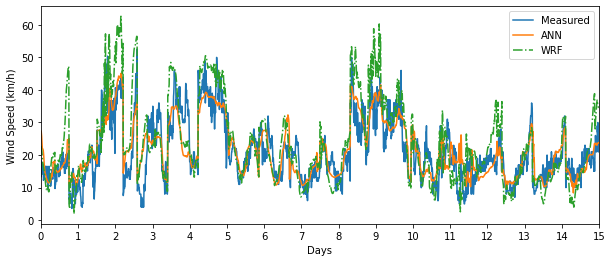

In [268]:
fig,ax = plt.subplots(figsize=(10,4))
plt.plot(mergedf.Wind_Speed_y.values,label = 'Measured')
plt.plot(mergedf.Predicted_Power_y.values,label = 'ANN')
plt.plot(mergedf.Ws_y.values*3.6,'-.',label = 'WRF')
plt.ylabel('Wind Speed (km/h)')
plt.legend()
ax.autoscale(enable=True, axis='x', tight=True)
xaux = np.arange(0,np.floor(len(mergedf.Wind_Speed_y.values)/(24*6)))

ax.set_xticks(np.linspace(0,len(mergedf.Wind_Speed_y.values),len(xaux)))
ax.set_xticklabels([int(i) for i in xaux])


plt.xlabel('Days')
#fig.savefig('wind_timeplot.pdf',bbox_inches = 'tight')

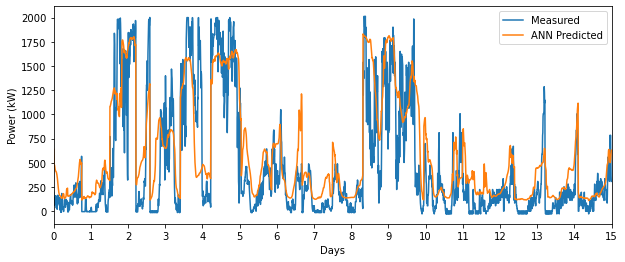

In [267]:
fig,ax = plt.subplots(figsize=(10,4))
plt.plot(mergedf.Power_x.values,label = 'Measured')
plt.plot(mergedf.Predicted_Power_x.values,label = 'ANN Predicted')

xaux = np.arange(0,np.floor(len(mergedf.Predicted_Power_x.values)/(24*6)))
ax.set_xticks(np.linspace(0,len(mergedf.Predicted_Power_x.values),len(xaux)))
ax.set_xticklabels([int(i) for i in xaux])

plt.xlabel('Days')
plt.ylabel('Power (kW)')
plt.legend()
plt.xlim([0, 2420.8])
plt.show()
#ax.autoscale(enable=True, axis='x', tight=True)
#fig.savefig('forecast_timeplot.pdf',bbox_inches = 'tight')

#### All the statistics of the four models in one dataframe

In [57]:
df_all_stats = pd.concat([pd.DataFrame(all_stats),
           pd.DataFrame(val_stats),
           pd.DataFrame(base1_stats),
           pd.DataFrame(base2_stats)])
df_all_stats.index = ['R2_test','MAE_test','RMSE_test','MedAE_test','ME_test',
                     'R2_val','MAE_val','RMSE_val','MedAE_val','ME_val',
                     'R2_base','MAE_base','RMSE_base','MedAE_base','ME_base',
                     'R2_hybrid','MAE_hybrid','RMSE_hybrid','MedAE_hybrid','ME_hybrid']
r2_df = df_all_stats.iloc[0::5].T
mae_df = df_all_stats.iloc[1::5].T
rmse_df = df_all_stats.iloc[2::5].T
medae_df = df_all_stats.iloc[3::5].T
me_df = df_all_stats.iloc[4::5].T

In [58]:
def plotbar(df,ylabel,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=(14,5))
    df.plot.bar(ax=ax,rot=0)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_ylabel(ylabel)
    plt.legend(loc=1)
    plt.show()
    return fig,ax

In [59]:
rmse_df.RMSE_base-rmse_df.RMSE_hybrid

WTG01     7.631654
WTG02    13.478718
WTG03     6.807379
WTG04     5.494688
WTG05     2.733471
WTG06     3.945302
WTG07     5.201607
WTG08     5.889503
WTG09     6.543268
WTG10     5.559276
WTG11     2.213471
WTG12     5.808422
WTG13     2.384509
WTG14     3.231570
WTG15     3.219360
WTG16     3.673000
dtype: float64

In [60]:
mae_df.MAE_base-mae_df.MAE_hybrid

WTG01    4.718571
WTG02    9.513810
WTG03    4.357093
WTG04    3.542996
WTG05    1.859973
WTG06    2.571958
WTG07    3.036179
WTG08    4.138219
WTG09    4.810110
WTG10    3.622384
WTG11    1.078683
WTG12    3.579365
WTG13    2.255465
WTG14    1.970787
WTG15    1.838422
WTG16    1.751400
dtype: float64

In [61]:
np.mean(rmse_df.RMSE_base-rmse_df.RMSE_val)

3.957074982786833

In [62]:
mae_df.max()

MAE_test      11.922272
MAE_val       13.003373
MAE_base      18.933544
MAE_hybrid    11.751821
dtype: float64

In [63]:
print(mae_df.std())
print(rmse_df.std())
print(medae_df.std())
print(me_df.std())

MAE_test      0.943111
MAE_val       0.930885
MAE_base      1.763521
MAE_hybrid    0.770973
dtype: float64
RMSE_test      1.164291
RMSE_val       1.453214
RMSE_base      2.382999
RMSE_hybrid    1.307400
dtype: float64
MedAE_test      0.872454
MedAE_val       0.623465
MedAE_base      0.905052
MedAE_hybrid    0.463782
dtype: float64
ME_test      8.140678
ME_val       8.246340
ME_base      3.725459
ME_hybrid    8.381833
dtype: float64


MAE_test       9.512170
MAE_val       11.683933
MAE_base      13.692148
MAE_hybrid    10.276810
dtype: float64


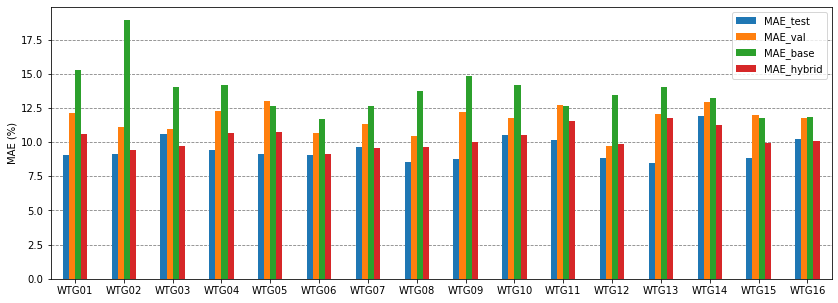

In [64]:
print(mae_df.mean())
fig,ax = plotbar(mae_df,'MAE (%)')
#fig.savefig('mae_final.pdf')

RMSE_test      13.787468
RMSE_val       17.416568
RMSE_base      21.373643
RMSE_hybrid    16.135193
dtype: float64


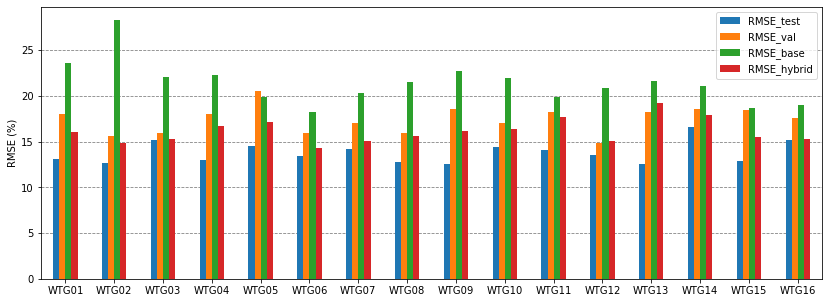

In [65]:
print(rmse_df.mean())
fig,ax = plotbar(rmse_df,'RMSE (%)')
#fig.savefig('rmse_final.pdf')

MedAE_test      6.077417
MedAE_val       7.052662
MedAE_base      7.283510
MedAE_hybrid    5.592682
dtype: float64


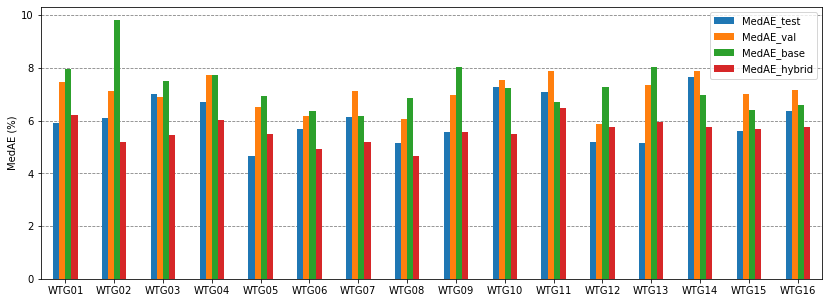

In [66]:
print(medae_df.mean())
fig,ax = plotbar(medae_df,'MedAE (%)')
#fig.savefig('medae_final.pdf')

ME_test      88.134861
ME_val       83.034152
ME_base      92.423168
ME_hybrid    82.795153
dtype: float64


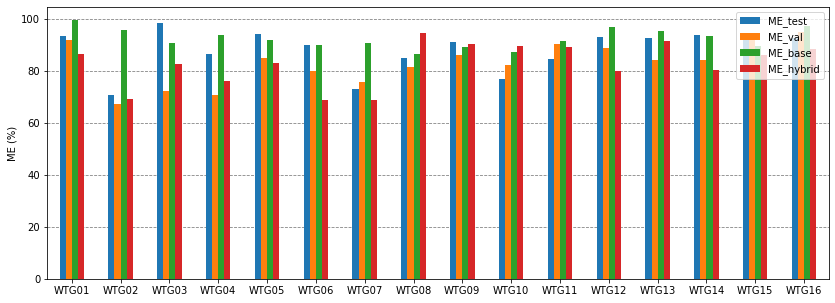

In [67]:
print(me_df.mean())
fig,ax = plotbar(me_df,'ME (%)')
#fig.savefig('me_final.pdf')

### Sensitivity analysis

In [85]:
for wt in wt_list:
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Power',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=9,
                                time_jump=3,
                                q_weight=q_weight,
                                quantile=quantile,
                                include_tanh = include_tanh,
                                patience = 2,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 0)  # Create and fit the model 
    wnn.predict_and_getmetrics_test()
    all_stats_tmp[wt] = wnn.stats

In [69]:
print(np.mean([all_stats[wt] for wt in wt_list],axis=0))

[0.8081281062749173, 9.541472038403349, 13.728070553802167, 6.211478234340081, 88.18247703982294]


In [87]:
all_info = []
for include_tanh in [True,False]:
    for look_back in [9,12]:
        for q_weight in [1.25,1.5,1.75]:
            for quantile in [0.5,0.6,0.7]:

                all_stats_tmp = {}
                for wt in wt_list:
                    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Power',
                                                features=['Ws', 'Wdir', 'T','P'],
                                                look_back=look_back,
                                                time_jump=1,
                                                q_weight=q_weight,
                                                quantile=quantile,
                                                include_tanh = include_tanh,
                                                patience = 2,
                                                epochs = 45,
                                                scaler = 'Standard') #Initialize it with the loaded data
                    wnn.prep_data()#Prepare the data
                    wnn.create_and_fit_model(verbose = 0)  # Create and fit the model 
                    wnn.predict_and_getmetrics_test()
                    all_stats_tmp[wt] = wnn.stats

                for wt in all_stats_tmp:  # convert stats into percentge except for R2
                    tmp = all_stats_tmp[wt]
                    tmp[2] = np.sqrt(tmp[2])
                    all_stats_tmp[wt] = [tmp[0]] + [100*i / nominal_power[wt] for i in tmp[1:]]    

                tmp = list(np.mean([all_stats_tmp[wt] for wt in wt_list],axis=0))    

                all_info.append([include_tanh,look_back,1,q_weight,quantile]+tmp)
                print(all_info[-1])                    

[True, 9, 1, 1.25, 0.5, 0.7858293915593738, 9.82749861663373, 14.465046629918287, 6.069526255734067, 91.82066952924966]
[True, 9, 1, 1.25, 0.6, 0.7867225385589125, 9.897115100268572, 14.435273477733466, 6.238880226650053, 91.13041431806298]
[True, 9, 1, 1.25, 0.7, 0.7892130301818499, 9.890864037202897, 14.354738384442035, 6.195566618081055, 91.12244479222099]
[True, 9, 1, 1.5, 0.5, 0.8016668432853684, 9.594235042610466, 13.956175620598195, 6.171162818126419, 89.62881731426101]
[True, 9, 1, 1.5, 0.6, 0.7951810170735738, 9.880045981328614, 14.171778291079304, 6.394596591517097, 89.86021746703975]
[True, 9, 1, 1.5, 0.7, 0.7907221536314535, 9.761320098643719, 14.328462537768218, 6.079529870689708, 90.85969736457331]
[True, 9, 1, 1.75, 0.5, 0.7765089766724483, 10.370443804522747, 14.791700872537948, 6.840992404910784, 90.32742737950586]
[True, 9, 1, 1.75, 0.6, 0.7855583802032593, 10.13158821833925, 14.5205409257967, 6.536154092175133, 89.86906077066598]
[True, 9, 1, 1.75, 0.7, 0.78580385319

In [137]:
all_info=[[True, 9, 1, 1.25, 0.5, 0.7858293915593738, 9.82749861663373, 14.465046629918287, 6.069526255734067, 91.82066952924966],
[True, 9, 1, 1.25, 0.6, 0.7867225385589125, 9.897115100268572, 14.435273477733466, 6.238880226650053, 91.13041431806298],
[True, 9, 1, 1.25, 0.7, 0.7892130301818499, 9.890864037202897, 14.354738384442035, 6.195566618081055, 91.12244479222099],
[True, 9, 1, 1.5, 0.5, 0.8016668432853684, 9.594235042610466, 13.956175620598195, 6.171162818126419, 89.62881731426101],
[True, 9, 1, 1.5, 0.6, 0.7951810170735738, 9.880045981328614, 14.171778291079304, 6.394596591517097, 89.86021746703975],
[True, 9, 1, 1.5, 0.7, 0.7907221536314535, 9.761320098643719, 14.328462537768218, 6.079529870689708, 90.85969736457331],
[True, 9, 1, 1.75, 0.5, 0.7765089766724483, 10.370443804522747, 14.791700872537948, 6.840992404910784, 90.32742737950586],
[True, 9, 1, 1.75, 0.6, 0.7855583802032593, 10.13158821833925, 14.5205409257967, 6.536154092175133, 89.86906077066598],
[True, 9, 1, 1.75, 0.7, 0.785803853197562, 9.919932241335903, 14.502007700533111, 6.083187436843307, 90.7865843156303],
[True, 12, 1, 1.25, 0.5, 0.7970555392854286, 9.712987706113557, 14.169236522654362, 6.101477374486446, 88.67138797262525],
[True, 12, 1, 1.25, 0.6, 0.8119110916461157, 9.147417867770983, 13.616920721642844, 5.571294014576114, 89.39500929949364],
[True, 12, 1, 1.25, 0.7, 0.8053642483087013, 9.240282816299466, 13.845145602639423, 5.540942053827027, 89.0107339150581],
[True, 12, 1, 1.5, 0.5, 0.8176330184609165, 9.105813371300748, 13.374934734601847, 5.731843234197413, 87.23326066387787],
[True, 12, 1, 1.5, 0.6, 0.7964091181793056, 9.742479607625004, 14.170120946699834, 6.111572134842383, 88.88572026879278],
[True, 12, 1, 1.5, 0.7, 0.7993876387890875, 9.52895217609889, 14.051998203690287, 5.822483194504914, 88.86507819313178],
[True, 12, 1, 1.75, 0.5, 0.7942304863601184, 9.83591425840855, 14.253269125554345, 6.300408103604233, 88.37920457608823],
[True, 12, 1, 1.75, 0.6, 0.8020199630403807, 9.671730908755553, 13.959801774300967, 6.123432595085875, 86.92489642013528],
[True, 12, 1, 1.75, 0.7, 0.8052232477120354, 9.514596748785802, 13.869028231546348, 5.920837939424757, 87.45762153673276],
[False, 9, 1, 1.25, 0.5, 0.7843675487050858, 10.357758481305986, 14.53203139489463, 7.11530718000709, 88.78330777242724],
[False, 9, 1, 1.25, 0.6, 0.7838929210180579, 10.266639960644598, 14.537776417011948, 6.90139469499295, 91.62638852179815],
[False, 9, 1, 1.25, 0.7, 0.7891366468625434, 10.119982783012057, 14.379140778728463, 6.682258733664638, 91.06605537301922],
[False, 9, 1, 1.5, 0.5, 0.7744022995197551, 10.688449741769587, 14.839700996263518, 7.595332476810938, 90.46439393789878],
[False, 9, 1, 1.5, 0.6, 0.7845810615093081, 10.380310443404788, 14.507266621349116, 7.1740114633672745, 87.86646480205947],
[False, 9, 1, 1.5, 0.7, 0.8013945875830578, 9.955913197257665, 13.954865414385633, 6.850296490165437, 93.64574085847626],
[False, 9, 1, 1.75, 0.5, 0.7804369213116145, 10.808766452994966, 14.670561416706194, 7.966072710550394, 88.35776493491156],
[False, 9, 1, 1.75, 0.6, 0.7855686336506416, 10.467229251354201, 14.481060173826249, 7.430008835499453, 92.37432223166248],
[False, 9, 1, 1.75, 0.7, 0.7669462271867005, 11.057079184469497, 15.082025665677843, 7.9055546776082295, 87.89743894421521],
[False, 12, 1, 1.25, 0.5, 0.7910882384319791, 10.244904476362098, 14.334428418717351, 7.1318195286169175, 87.33268262201142],
[False, 12, 1, 1.25, 0.6, 0.803733877497212, 9.806457187384353, 13.896480871705473, 6.650468554110805, 88.76363528449772],
[False, 12, 1, 1.25, 0.7, 0.7914433091008058, 10.166442899718575, 14.340349276720755, 6.867844230829026, 88.69006119552715],
[False, 12, 1, 1.5, 0.5, 0.7857577126947856, 10.504890214091033, 14.517062573772728, 7.48687076697963, 91.16020546503563],
[False, 12, 1, 1.5, 0.6, 0.8023434702487712, 9.841150435209428, 13.958096903782637, 6.5942667193971065, 86.00603560059928],
[False, 12, 1, 1.5, 0.7, 0.7952900960804697, 9.847622809541111, 14.147253165989078, 6.44239663299733, 88.07338053020526],
[False, 12, 1, 1.75, 0.5, 0.8004906649940043, 10.173206140864519, 14.041051770514132, 7.282755539879668, 85.204973668374],
[False, 12, 1, 1.75, 0.6, 0.8055599584860977, 9.797701918119584, 13.815812636679384, 6.717907373520287, 92.40808776401043],
[False, 12, 1, 1.75, 0.7, 0.7860842553140495, 10.309273723188614, 14.514052609468234, 6.950930638435207, 85.452517358223]]

In [138]:
dfa = pd.DataFrame(data = all_info,
                   columns = ['include_tanh','look_back','time_jump','q_weight','quantile','R2','MAE','RMSE','MedAE','ME'])

In [139]:
dfa.style.highlight_min(color = 'lightgreen',  
                       axis = 0,subset = ['MAE','RMSE','MedAE','ME']) 

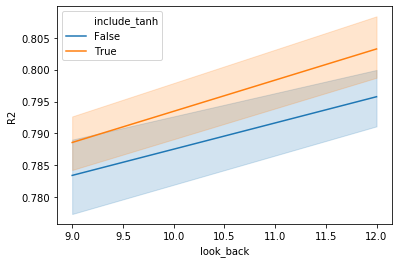

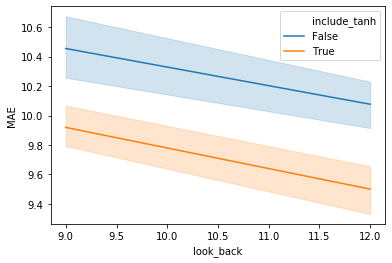

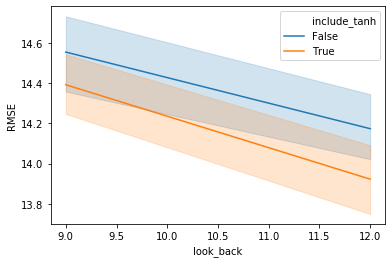

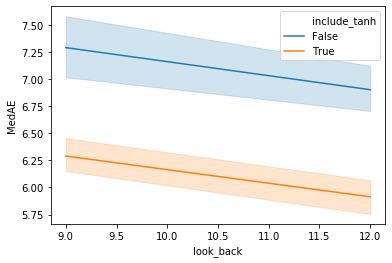

In [155]:
for m in ['R2','MAE','RMSE','MedAE']:
    fig ,ax = plt.subplots()
    sns.lineplot(data = dfa, y = m ,x = 'look_back',hue = 'include_tanh',legend ='full')
    #fig.savefig('figures\\'+m+'_one.png',dpi=150,bbox_inches='tight')

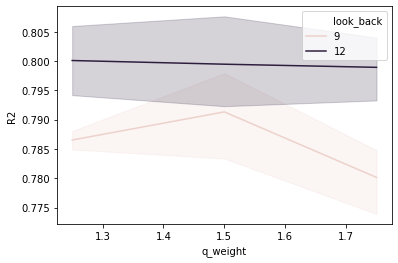

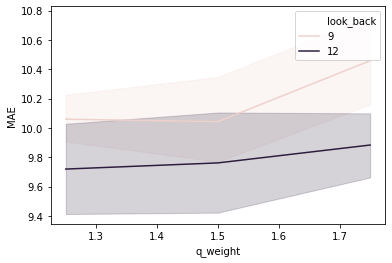

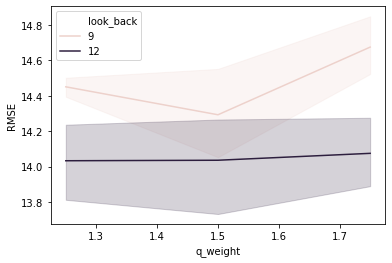

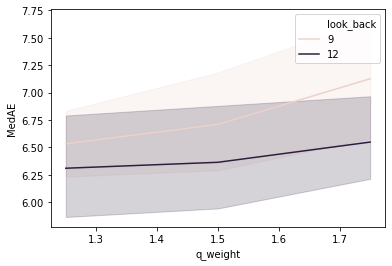

In [156]:
for m in ['R2','MAE','RMSE','MedAE']:
    fig ,ax = plt.subplots()
    sns.lineplot(data = dfa, y = m ,x = 'q_weight',hue = 'look_back',legend ='full')
    #fig.savefig('figures\\'+m+'_two.png',dpi=150,bbox_inches='tight')

In [ ]:
[True, 6, 1, 1.25, 0.5, 0.7700573381409777, 10.413532324727868, 14.953788211532313, 6.715839271981819, 93.00920986720357]
[True, 6, 1, 1.25, 0.6, 0.7629818391760936, 10.546102472031563, 15.216894095126406, 6.757506183535683, 93.0511695591266]
[True, 6, 1, 1.25, 0.7, 0.7757802503560617, 10.189976244123619, 14.80725172419567, 6.516408282968213, 93.20902140345378]
[True, 6, 1, 1.5, 0.5, 0.7711924417883537, 10.534813524620088, 14.969372603055694, 7.001234778063011, 92.09631592515314]
[True, 6, 1, 1.5, 0.6, 0.7774935527380551, 10.323196203440407, 14.733477203483776, 6.751174479214278, 93.65308906621951]
[True, 6, 1, 1.5, 0.7, 0.7726889304471751, 10.385673952548832, 14.89134153830529, 6.658363847415791, 92.27543934903142]
[True, 6, 1, 1.75, 0.5, 0.7622702728587386, 10.941693005177186, 15.244294281353358, 7.52335266153782, 91.98751495102859]
[True, 6, 1, 1.75, 0.6, 0.76673735582911, 10.604467702426366, 15.092604815815882, 6.920997829355133, 92.42568725115159]
[True, 6, 1, 1.75, 0.7, 0.7647707571597245, 10.592864357652934, 15.169033942590108, 6.788101942348835, 92.80914864569927]
[True, 6, 2, 1.25, 0.5, 0.7587798566783941, 10.674427382197727, 15.357787649268127, 6.834529626573905, 94.34004907078213]
[True, 6, 2, 1.25, 0.6, 0.7660231451850223, 10.60815757648288, 15.123567924928626, 6.938318074764991, 93.31575607298618]
[True, 6, 2, 1.25, 0.7, 0.7633633742729755, 10.526992785745996, 15.20389268649371, 6.677137173220553, 93.61637289529796]
[True, 6, 2, 1.5, 0.5, 0.7623128087486534, 10.683751174038566, 15.247127902707623, 7.0150374842485705, 93.28719755218808]
[True, 6, 2, 1.5, 0.6, 0.7620869291181056, 10.707313693182547, 15.239902274755009, 6.97832629015705, 92.91712028639108]
[True, 6, 2, 1.5, 0.7, 0.7568621034589779, 10.810694997124479, 15.39442465717241, 7.046201912475991, 92.04528893254977]
[True, 6, 2, 1.75, 0.5, 0.757703542019027, 10.861266279679441, 15.347548429631999, 7.320993727404228, 93.93528293237237]
[True, 6, 2, 1.75, 0.6, 0.7519393465508339, 11.165372718420986, 15.562143804574523, 7.585706161834457, 92.53458574871462]
[True, 6, 2, 1.75, 0.7, 0.7578794264771527, 10.95256427884004, 15.37580025433099, 7.283157873905552, 92.9791745763755]
[True, 6, 3, 1.25, 0.5, 0.7595269973368177, 10.844974015543299, 15.33969386321514, 7.187309507654197, 92.12069844590347]
[True, 6, 3, 1.25, 0.6, 0.7552368827344939, 10.93369520018622, 15.471071766412239, 7.27447790744402, 92.42303752521616]
[True, 6, 3, 1.25, 0.7, 0.7603861194960465, 10.603969716670171, 15.310361808978284, 6.710045656182503, 93.92032997901846]
[True, 6, 3, 1.5, 0.5, 0.7543377571445242, 10.998989960651969, 15.493879562772895, 7.381060831552192, 92.61891121490918]
[True, 6, 3, 1.5, 0.6, 0.7535881754796835, 11.142087556175795, 15.535314316136583, 7.557097188211441, 91.18896017928903]
[True, 6, 3, 1.5, 0.7, 0.7506284939793862, 11.06099319175524, 15.621104582751638, 7.283777925702877, 92.40898045921224]
[True, 6, 3, 1.75, 0.5, 0.7470758043152881, 11.552964090460137, 15.723652767982019, 8.353601020993874, 91.89436327188331]
[True, 6, 3, 1.75, 0.6, 0.7539541493839541, 11.164102022645746, 15.516218729103652, 7.544810679725298, 92.13074551910461]
[True, 6, 3, 1.75, 0.7, 0.7513457165764561, 11.21355566250059, 15.595036975201308, 7.533735399370842, 91.96565084083592]
[True, 9, 1, 1.25, 0.5, 0.7967687516833009, 9.691172658194343, 14.134531207115867, 6.110223578281541, 90.74652706691715]
[True, 9, 1, 1.25, 0.6, 0.7977467244189134, 9.543130761631446, 14.059076120181173, 5.846925244022347, 90.73097596370854]
[True, 9, 1, 1.25, 0.7, 0.7985635125167724, 9.448698895239714, 14.057355559181236, 5.685597341929316, 90.89495128432905]
[True, 9, 1, 1.5, 0.5, 0.7935374297229287, 9.794774831427532, 14.225370905079318, 6.304218625609679, 90.51414596532537]
[True, 9, 1, 1.5, 0.6, 0.7900030366096468, 9.96191215998233, 14.34846551612908, 6.380279700979443, 91.10537174633654]
[True, 9, 1, 1.5, 0.7, 0.7869302217065605, 9.844591275802445, 14.42834234910991, 6.0373052301182, 92.13124517617729]
[True, 9, 1, 1.75, 0.5, 0.7908608457848404, 9.908741107954958, 14.248803894349422, 6.48023676946316, 89.04046813453373]
[True, 9, 1, 1.75, 0.6, 0.7770352442681483, 10.243035136127103, 14.786425410513726, 6.579953498673264, 89.84544483506515]
[True, 9, 1, 1.75, 0.7, 0.7981582734574252, 9.817657207040014, 14.072133659480196, 6.280010923511649, 88.95140188051303]